In [1]:
import os, sys
NB_ROOT = os.getcwd()
CODE_ROOT = os.path.dirname(os.path.dirname(NB_ROOT))
ENV_ROOT = f"{CODE_ROOT}/environment"

#### `MDP: Markov Decision Process`

In [2]:
## imports
import matplotlib.pyplot as plt
import numpy as np
import math
import pickle
import os, sys
sys.path.append(CODE_ROOT);sys.path.append(ENV_ROOT)
from environment.racedemia_env_v1 import Racedemia_Env

conf_fpath = r'D:\meow_racer_experiments\nam_c_logs\0612_SingleFeet_DTx50_NAM_MEDIUM_Act3_Center_timePen_minVPen_offCnt_VelReward_ProgressReward1000_Weighted_3_SmallEphi_LargeAggWeight'.replace('\\', '/')
conf = pickle.load(open(f"{conf_fpath}/conf_dict.pkl", "rb"))

car_config_yaml_path = f"{ENV_ROOT}/vehicle/jw_config.yaml"

env = Racedemia_Env(
    plotter=None,
    environment_config=conf['environment'],
    agent_config=conf['agent'],
    penalty_config=conf['penalty'],
    reward_config=conf['reward'],
    style_config=conf['style'],
    # render_config=conf['simulate'],
    render_config=None,
    is_nam=True,
    mode='train',
    terminated_fig_path=None,
    exp_name=os.path.splitext(conf_fpath)[-1]
)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
env.car.bicycle_model._reset(config_yaml_path = car_config_yaml_path,
               init_x = env.track_dict['x'][0] + 2,
               init_y = env.track_dict['y'][0] + 0.5,
               init_phi = env.track_dict['phi'][0],
               init_kappa = env.track_dict['kappa'][0],
               init_vx = 1.)
s, r, t1, t2, _ = env.step(action=None)

In [24]:
bm = env.car.bicycle_model
lidar_obj = env.lidar_sensor_obj
forward_obj = env.forward_vector_obj
lookahead_obj = env.lookahead_obj
theta_center_spline = env.car.theta_center_spline

In [26]:
env.car.bicycle_model.dCar_y, env.car.bicycle_model.dCar_x

(0, 0)

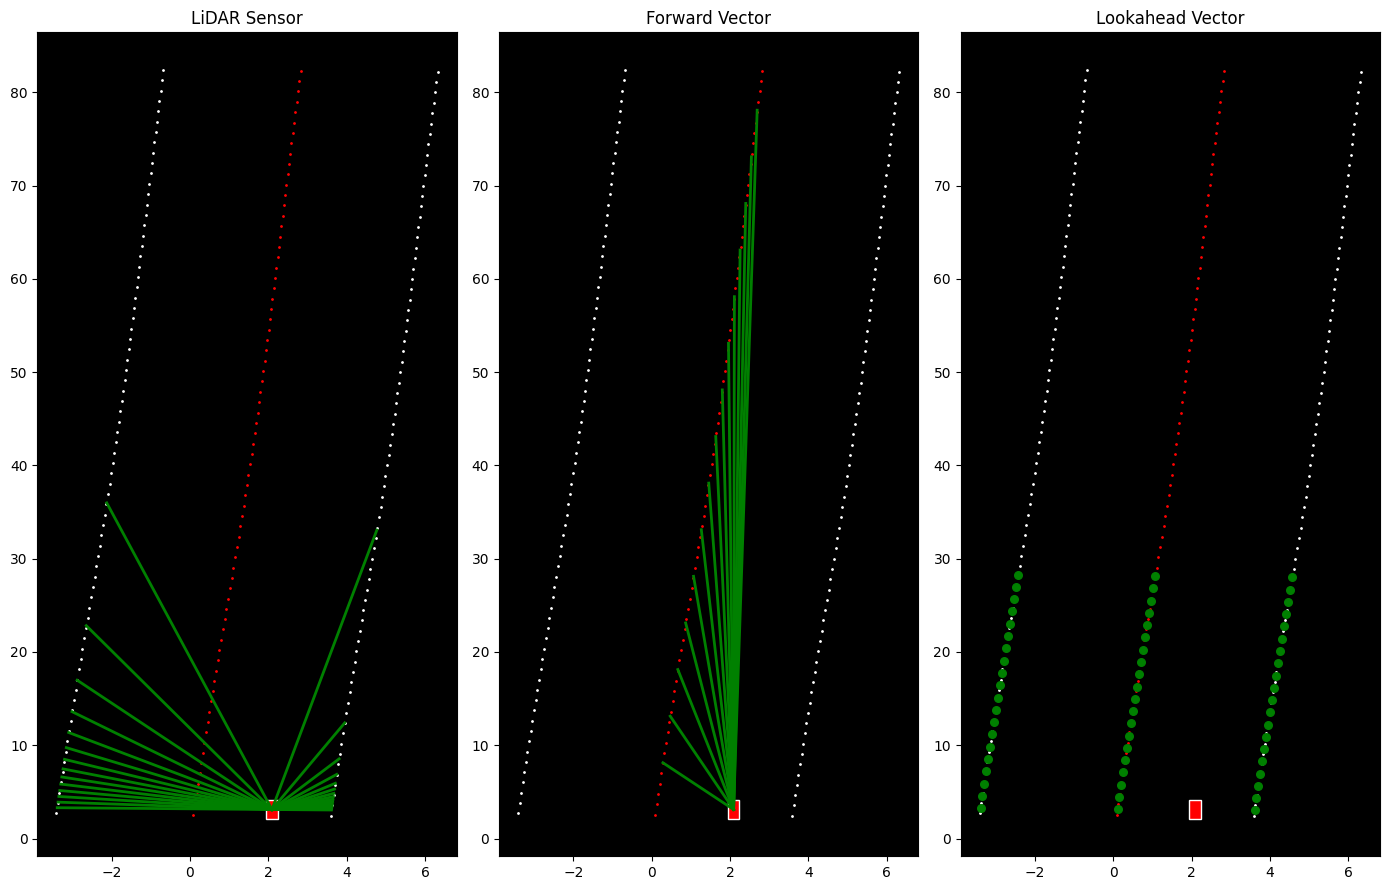

In [37]:
import matplotlib.patches as patches
track_dict = env.track_dict
ref_theta = bm.ref_arr_dict['theta'][-1]
car_x, car_y = bm.car_x, bm.car_y
fig, ax = plt.subplots(1, 3, figsize=(14, 9))

##draw the track
for j in range(3):
    for i, (x, y, theta) in enumerate(zip(track_dict['x'], track_dict['y'], track_dict['theta'])):
        if theta > ref_theta + 80:
            break
        ax[j].scatter(x, y, s=1, c='r')
        ax[j].scatter(track_dict['left'].T[0, i], track_dict['left'].T[1, i] ,s=1, c='w')
        ax[j].scatter(track_dict['right'].T[0, i],track_dict['right'].T[1, i], s=1, c='w')

##draw the LiDAR sensor
lidar_res = lidar_obj.lidar_results
for res in lidar_res:
    if res['distance'] != -1:
        ax[0].plot([car_x, res['point'][0]], [car_y, res['point'][1]], linewidth=2, c='g')

ax[0].set_title("LiDAR Sensor")
ax[0].set_facecolor("black")

##draw the forward vector
for vx, vy in forward_obj.vector_dict['inertia']:
    ex, ey = vx + car_x, vy + car_y
    ax[1].plot([car_x, ex], [car_y, ey], linewidth=2, c='g')
ax[1].set_title("Forward Vector")
ax[1].set_facecolor("black")
##draw the lookahead coords
ref_theta = env.car.bicycle_model.ref_arr_dict['theta'][-1]
env.car.bicycle_model.dCar_x = -0.001 # 25 # - 0.00001
env.car.bicycle_model.dCar_y = 25 #0.04 # 25 # 32 #  -0.001 #32 #4 # 2
lookahead_coords = lookahead_obj._lookahead_coords(env.car.theta_center_spline, 
                                                   env.car.theta_left_spline,
                                                   env.car.theta_right_spline)
for i in range(0, 20):
    for j in range(3):
        ax[2].scatter(lookahead_coords[i][j], lookahead_coords[i+20][j], s=30, c='g')

ax[2].set_title("Lookahead Vector")
ax[2].set_facecolor("black")
##draw car for all axes##
w, h = 0.3, 2
# for i in range(1):
for i in range(3):
    rect = patches.Rectangle((car_x-w/2, car_y-h/2), w, h, linewidth=1, edgecolor='w', facecolor='r')
    ax[i].add_patch(rect)

fig.tight_layout()

#### `Environment`

In [4]:
import os, sys
sys.path.append(CODE_ROOT);sys.path.append(ENV_ROOT)

from environment.track import Nam_TrackGenerator, Bezier_TrackGenerator

nam_track_cfg_path = f"{CODE_ROOT}/statics/nam_c_track.pkl"
nam_track_gen = Nam_TrackGenerator(
    track_width=7, nam_track_path=nam_track_cfg_path, min_num_ckpt=4, max_num_ckpt=12
)
nam_track_gen._generate()
nam_track_dict = nam_track_gen._calculate_track_dict()
nam_track_cfg = pickle.load(open(nam_track_cfg_path, 'rb'))


bezier_track_gen = Bezier_TrackGenerator(
    min_num_ckpt=4, max_num_ckpt=16
)
bezier_track_gen._generate()
bezier_track_dict = bezier_track_gen._calculate_track_dict()


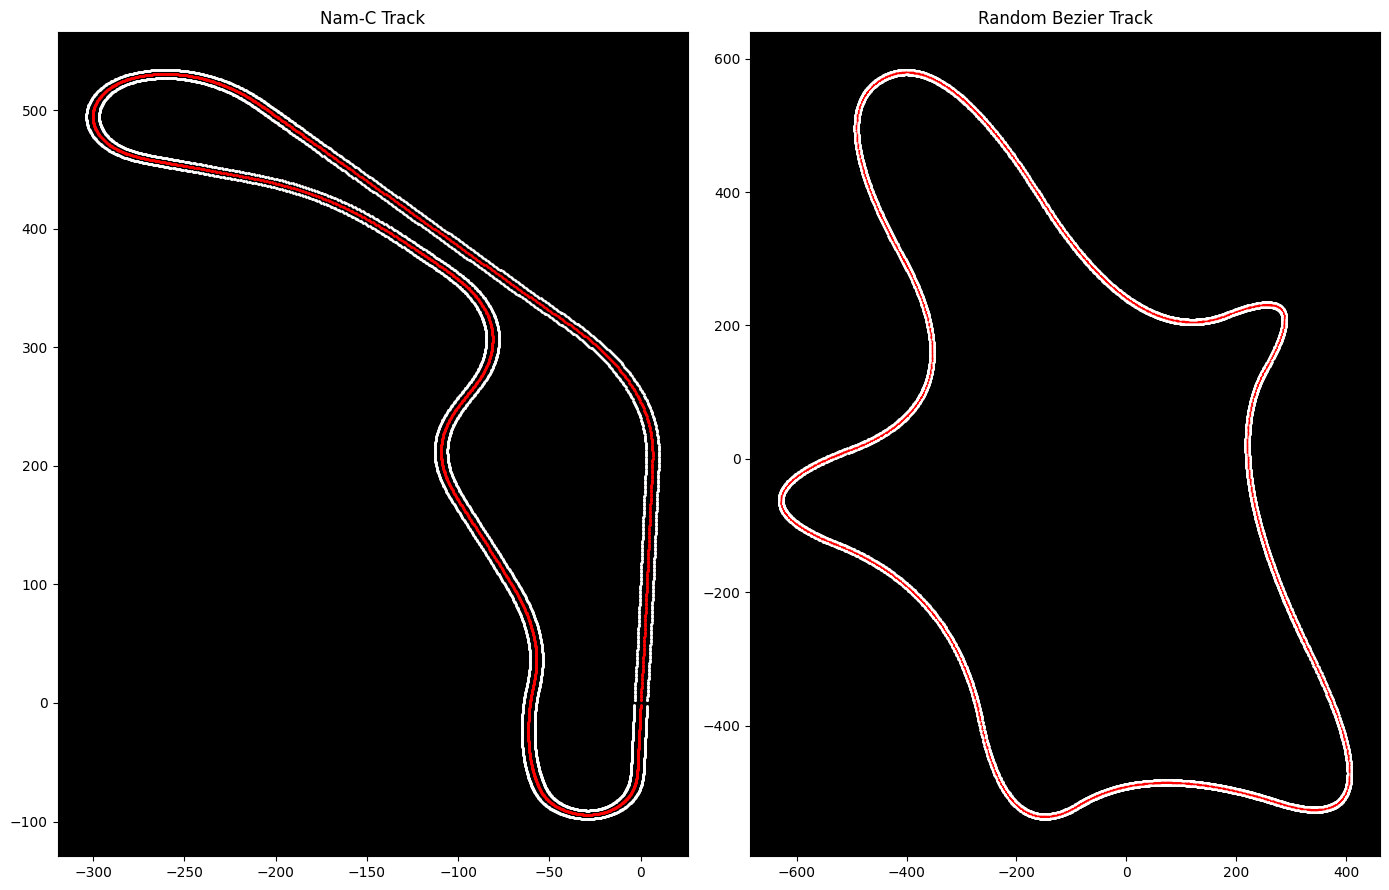

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 9))
plt.style.use("dark_background")

for i, (x, y) in enumerate(zip(nam_track_dict['x'], nam_track_dict['y'])):
    ax[0].scatter(x, y, s=1, c='r')
    ax[0].scatter(nam_track_dict['left'].T[0, i], nam_track_dict['left'].T[1, i] ,s=1, c='w')
    ax[0].scatter(nam_track_dict['right'].T[0, i],nam_track_dict['right'].T[1, i], s=1, c='w')
ax[0].set_title("Nam-C Track")
ax[0].set_facecolor("black")

for i, (x, y) in enumerate(zip(bezier_track_dict['x'], bezier_track_dict['y'])):
    ax[1].scatter(x, y, s=1, c='r')
    ax[1].scatter(bezier_track_dict['left'].T[0, i],bezier_track_dict['left'].T[1, i], s=1, c='w')
    ax[1].scatter(bezier_track_dict['right'].T[0, i],bezier_track_dict['right'].T[1, i], s=1, c='w')
ax[1].set_title("Random Bezier Track")
ax[1].set_facecolor("black")
# fig.tight_layout()

#### `Training Results`

In [5]:
from natsort import natsort
from glob import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

def _get_shortest_lap_epoch(exp_path, dt:float=0.05) -> int:
    success_paths = natsort.natsorted(glob(exp_path + "/success_*/car_state.pkl"))
    time_arr = [np.array(pickle.load(open(p, 'rb'))).shape[0] * dt for p in success_paths]
    min_idx = np.argmin(time_arr)
    
    epoch = success_paths[min_idx].split('/')[-2].split('_')[-1]
    
    return int(epoch)

def _get_best_reward_lap_epoch(exp_path, df:float=0.05) -> int:
    success_paths = natsort.natsorted(glob(exp_path + '/success_*/sarsa.pkl'))
    reward_arr = [np.array(pickle.load(p, 'rb')['reward']).sum() for p in success_paths]
    max_idx = np.argmax(reward_arr)
    
    epoch = success_paths[max_idx].split('/')[-2].split('_')[-1]
    
    return int(epoch)

def _return_info_paths(exp_path, epoch:int):
    car_status = np.array(pickle.load(open(f"{exp_path}/test/success_epoch_{epoch}/car_status.pkl", 'rb')))
    car_action = pickle.load(open(f"{exp_path}/test/success_epoch_{epoch}/ActionDim3_RawAction.pkl", 'rb'))
    car_state  = np.array(pickle.load(open(f"{exp_path}/test/success_epoch_{epoch}/car_state.pkl", 'rb')))
    
    return car_status, car_action, car_state


def _get_all_success_lap_time(exp_path):
    success_paths = natsort.natsorted(glob(exp_path + "/test/success_*/car_status.pkl"))
    success_status_arr = [pickle.load(open(p, "rb")) for p in success_paths]
    lap_time_arr = [np.array(s).shape[0] * 0.05 for s in success_status_arr]
    return np.array(lap_time_arr)
    

In [6]:
NAM_C_LOG_ROOT = r'D:\meow_racer_experiments\nam_c_logs'.replace('\\', '/')

DEFENSIVE_EXP='0606_SingleFeet_DTx50_NAM_Defensive_Act3_Center_timePen_minVPen_offCnt_VelReward_ProgressReward1000_Ec10_TermV02_SmoothControl'
MEDIUM_EXP='0612_SingleFeet_DTx50_NAM_MEDIUM_Act3_Center_timePen_minVPen_offCnt_VelReward_ProgressReward1000_Weighted_3_SmallEphi_LargeAggWeight'
AGGRESSIVE_EXP='0607_SingleFeet_DTx50_NAM_Aggressive_Act3_timePen01_minVPen_offCnt_NegVelAPSReward_PrgReward1000_PrgRewardVel1_KappaV1_Ephi01_HCV2NormK'

MEDIUM_EPOCH=118 #131 #64
DEFENSIVE_EPOCH=437 #324 #170
AGGRESSIVE_EPOCH=434 #372 #409 #320                                                                 

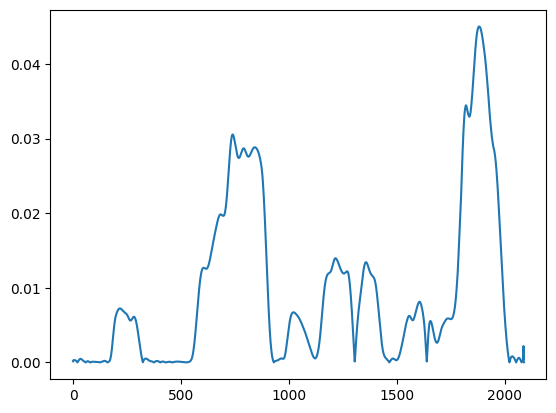

In [6]:
plt.plot(abs(nam_track_dict['kappa']))

In [88]:
# 0 500 1000 1650
# 500 1000 1650 2089

In [7]:
corner_meta = {
    'corner_segments': {
        1 : [0, 500],
        2: [500, 1000], 
        3: [1000, 1650],
        4: [1650, 2089]
    }
}

In [8]:
agg_car_status, agg_car_action, agg_car_state = _return_info_paths(exp_path=f"{NAM_C_LOG_ROOT}/{AGGRESSIVE_EXP}", epoch=AGGRESSIVE_EPOCH)
med_car_status, med_car_action, med_car_state = _return_info_paths(exp_path=f"{NAM_C_LOG_ROOT}/{MEDIUM_EXP}", epoch=MEDIUM_EPOCH)
def_car_status, def_car_action, def_car_state = _return_info_paths(exp_path=f"{NAM_C_LOG_ROOT}/{DEFENSIVE_EXP}", epoch=DEFENSIVE_EPOCH)

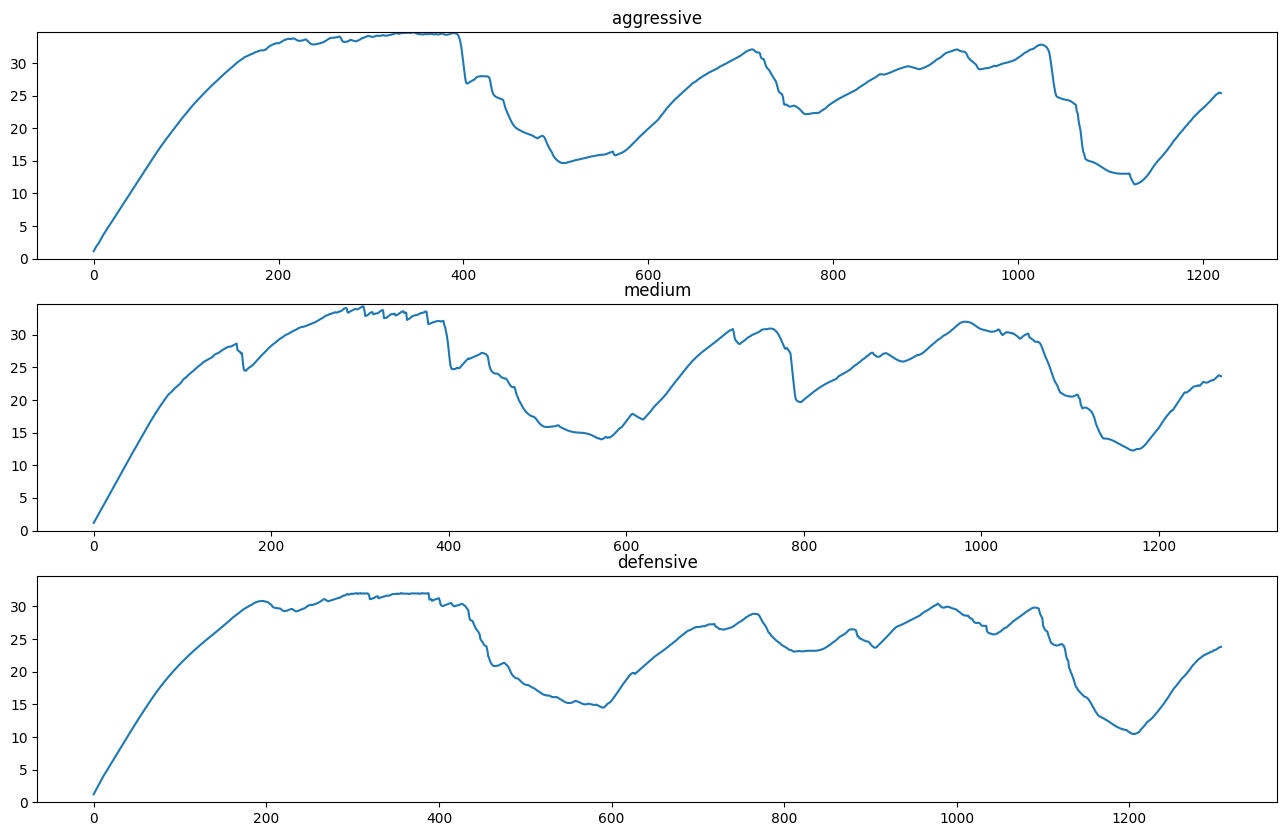

In [181]:
fig, ax = plt.subplots(3, 1, figsize=(16, 10))
ax[0].plot(agg_car_status.T[0]);ax[0].set_title("aggressive")
ax[1].plot(med_car_status.T[0]);ax[1].set_title("medium")
ax[2].plot(def_car_status.T[0]);ax[2].set_title("defensive")

max_v = max(max(agg_car_status.T[0]), max(def_car_status.T[0]), max(med_car_status.T[0]))
for i in  range(3):
    ax[i].set_ylim(0, max_v)

In [14]:
theta_spline = env.car.theta_center_spline

In [13]:
from scipy.optimize import minimize
import math

def dist_to_center(xy_spline, theta, X, Y):
    p = xy_spline(theta)
    dp = xy_spline(theta, nu=1)
    psi = np.arctan2(dp[1], dp[0])
    el = np.cos(psi)*(X-p[0]) + np.sin(psi) * (Y-p[1])
    
    return el**2

def _get_closest_theta(cx, cy, spline, track_dict):
    initial_guess = track_dict['theta'][np.argmin((track_dict['x']- cx)**2 + (track_dict['y'] - cy)**2)]
    if isinstance(initial_guess, int):
        initial_guess = track_dict[initial_guess]
        
    close_theta = minimize(lambda x:
                dist_to_center(spline, x[0], cx, cy), initial_guess
            ).x[0] # 첫 theta값으로 minimize optimization을 초기화
    return close_theta

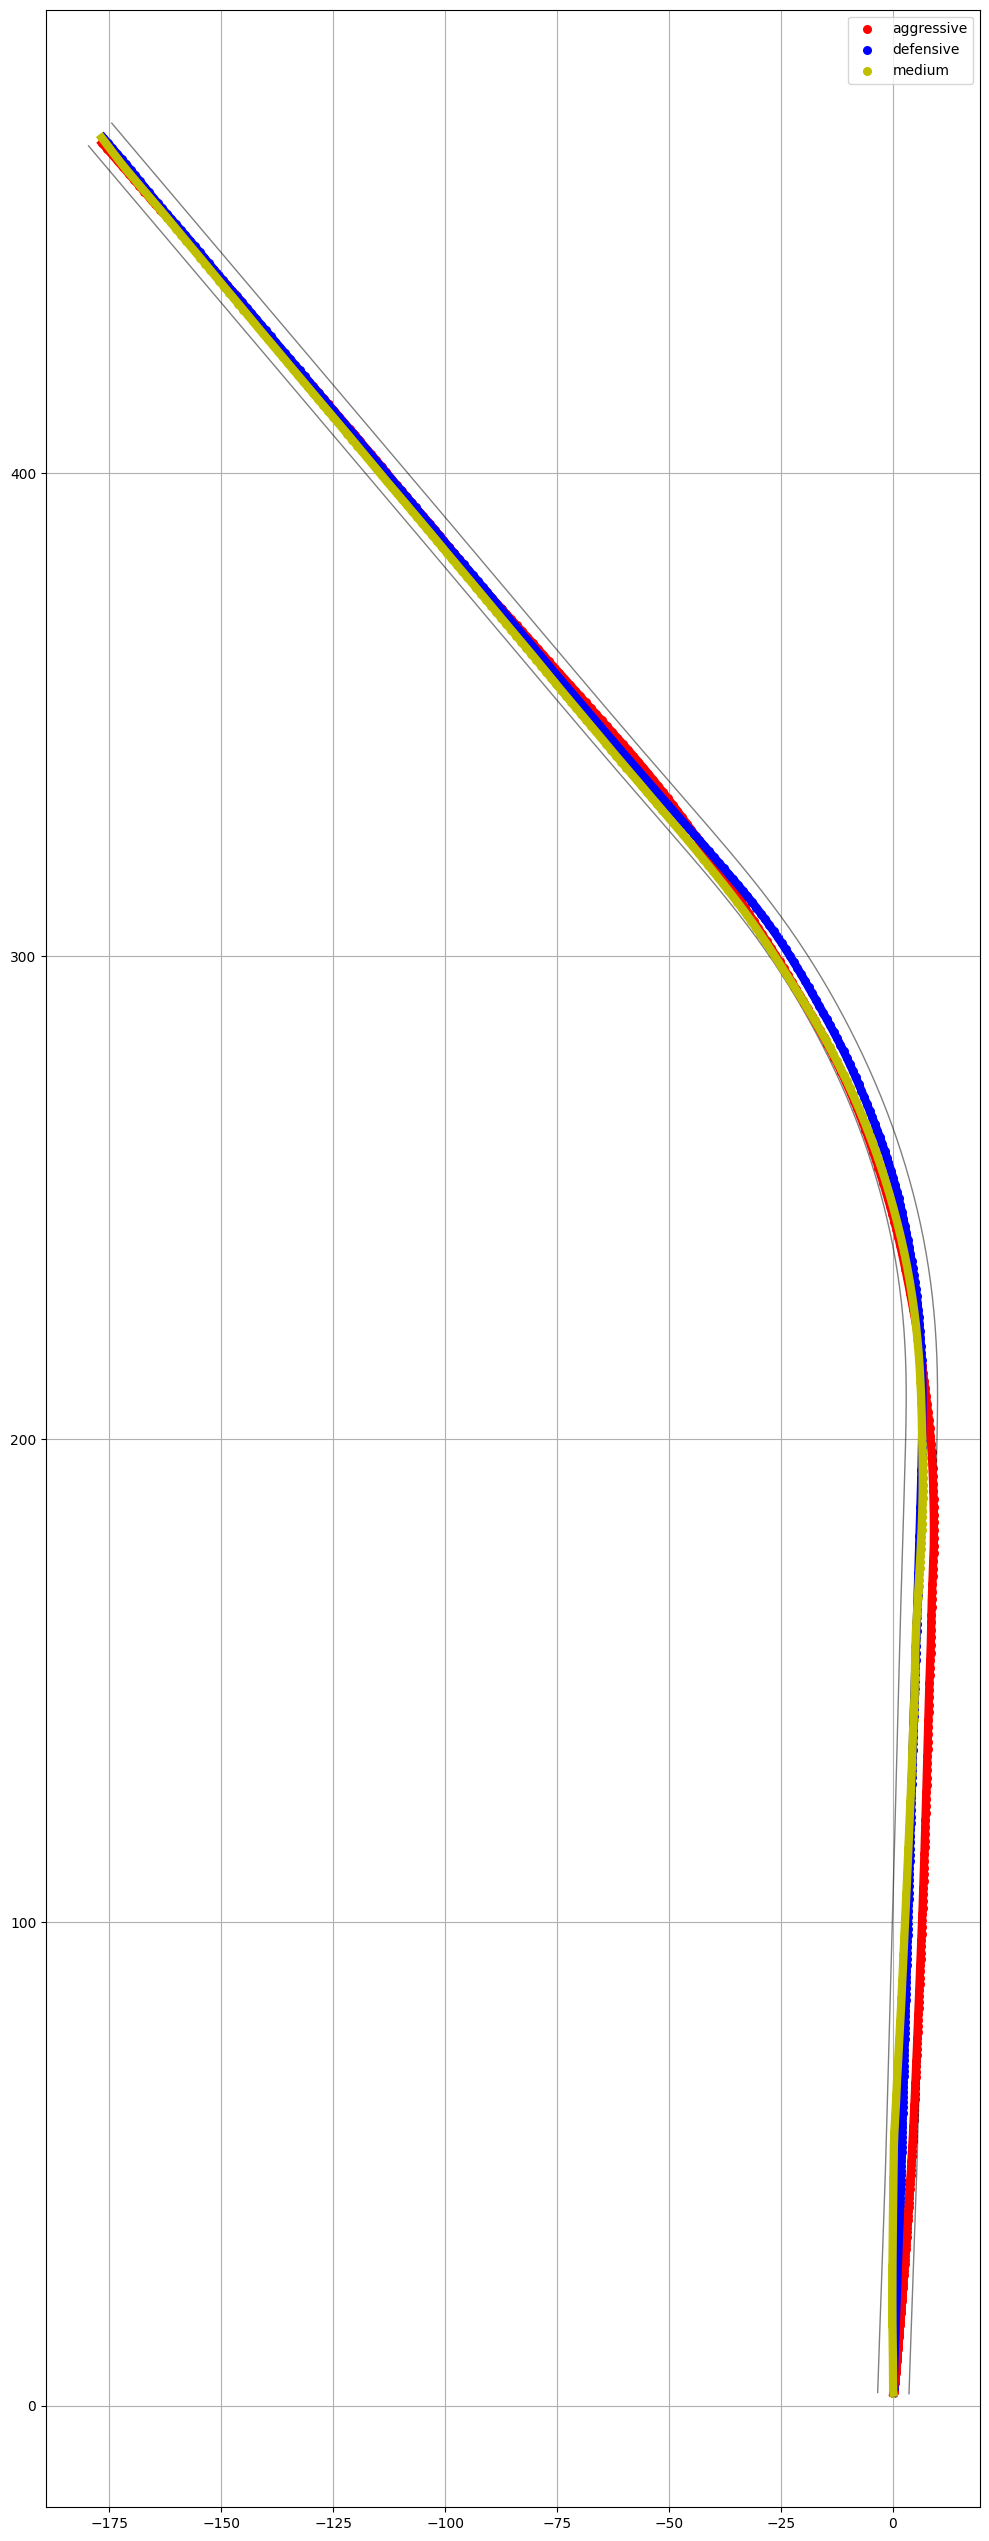

In [182]:
start = corner_meta['corner_segments'][1][0]
end = corner_meta['corner_segments'][1][1]

start_x, start_y = nam_track_dict['x'][start], nam_track_dict['y'][start]
end_x, end_y = nam_track_dict['x'][end], nam_track_dict['y'][end]

mx, Mx = min(nam_track_dict['x'][start:end]), max(nam_track_dict['x'][start:end])
my, My = min(nam_track_dict['y'][start:end]), max(nam_track_dict['y'][start:end])
diff_x, diff_y = abs(Mx - mx), abs(My - my)


fig, ax = plt.subplots(figsize=(10, 10 * (diff_y / diff_x)))
plt.plot(nam_track_dict['x'][start:end+1], nam_track_dict['y'][start:end+1], linewidth=1, c='k', alpha=0.1)
plt.plot(nam_track_dict['left'][start:end+1, 0], nam_track_dict['left'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)
plt.plot(nam_track_dict['right'][start:end+1, 0], nam_track_dict['right'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)

# for i in range(start, end+1):
#     plt.scatter(nam_track_dict['x'][i], nam_track_dict['y'][i], s=1, c='k', alpha=0.2)
#     plt.scatter(nam_track_dict['left'][i, 0], nam_track_dict['left'][i, 1], s=1, c='k', alpha=0.5)
#     plt.scatter(nam_track_dict['right'][i, 0], nam_track_dict['right'][i, 1], s=1, c='k', alpha=0.5)

agg_x, agg_y = agg_car_state[:, 0], agg_car_state[:, 1]
def_x, def_y = def_car_state[:, 0], def_car_state[:, 1]
med_x, med_y = med_car_state[:, 0], med_car_state[:, 1]

agg_pts = []
for i, (x, y) in enumerate(zip(agg_x, agg_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        agg_pts.append([x, y])
agg_pts = np.array(agg_pts).T


def_pts = []
for i, (x, y) in enumerate(zip(def_x, def_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        def_pts.append([x, y])
def_pts = np.array(def_pts).T

med_pts = []
for i, (x, y) in enumerate(zip(med_x, med_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        med_pts.append([x, y])
med_pts = np.array(med_pts).T

plt.scatter(agg_pts[0], agg_pts[1], c='r', s=30, label='aggressive');plt.plot(agg_pts[0], agg_pts[1], color='r', linewidth=6)
plt.scatter(def_pts[0], def_pts[1], c='b', s=30, label='defensive');plt.plot(def_pts[0], def_pts[1], color='b', linewidth=6)
plt.scatter(med_pts[0], med_pts[1], c='y', s=30, label='medium');plt.plot(med_pts[0], med_pts[1], color='y', linewidth=6)
    
    
fig.tight_layout()
plt.legend()
plt.grid()

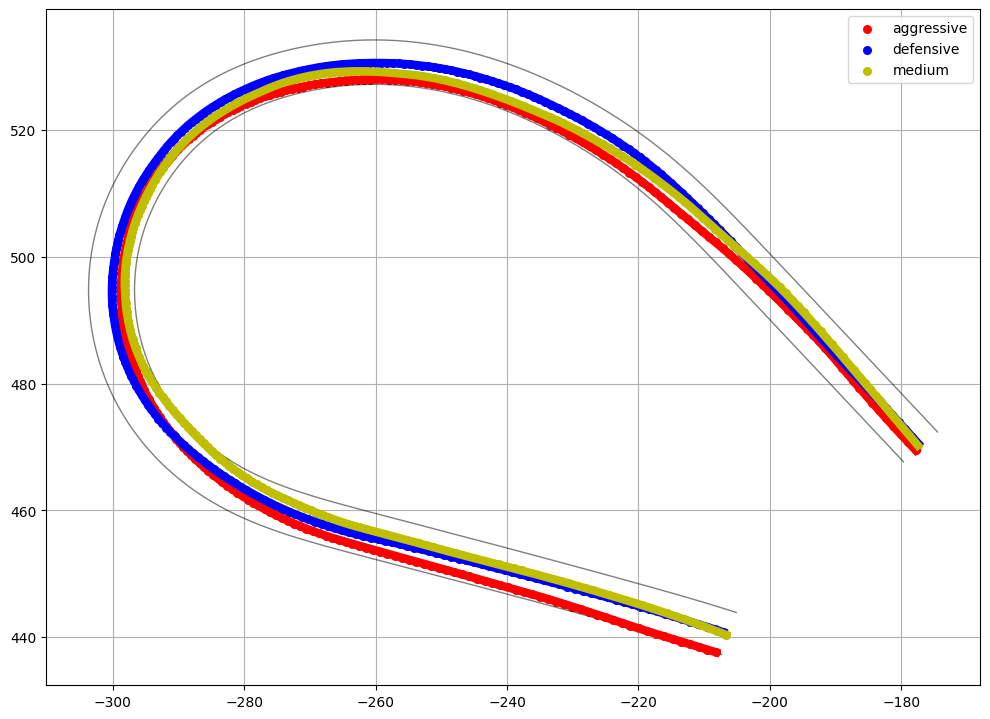

In [183]:
start = corner_meta['corner_segments'][2][0]
end = corner_meta['corner_segments'][2][1]

start_x, start_y = nam_track_dict['x'][start], nam_track_dict['y'][start]
end_x, end_y = nam_track_dict['x'][end], nam_track_dict['y'][end]

mx, Mx = min(nam_track_dict['x'][start:end]), max(nam_track_dict['x'][start:end])
my, My = min(nam_track_dict['y'][start:end]), max(nam_track_dict['y'][start:end])
diff_x, diff_y = abs(Mx - mx), abs(My - my)


fig, ax = plt.subplots(figsize=(10, 10 * (diff_y / diff_x)))
plt.plot(nam_track_dict['x'][start:end+1], nam_track_dict['y'][start:end+1], linewidth=1, c='k', alpha=0.1)
plt.plot(nam_track_dict['left'][start:end+1, 0], nam_track_dict['left'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)
plt.plot(nam_track_dict['right'][start:end+1, 0], nam_track_dict['right'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)
# for i in range(start, end+1):
#     plt.scatter(nam_track_dict['x'][i], nam_track_dict['y'][i], s=1, c='k', alpha=0.2)
#     plt.scatter(nam_track_dict['left'][i, 0], nam_track_dict['left'][i, 1], s=1, c='k', alpha=0.5)
#     plt.scatter(nam_track_dict['right'][i, 0], nam_track_dict['right'][i, 1], s=1, c='k', alpha=0.5)

agg_x, agg_y = agg_car_state[:, 0], agg_car_state[:, 1]
def_x, def_y = def_car_state[:, 0], def_car_state[:, 1]
med_x, med_y = med_car_state[:, 0], med_car_state[:, 1]

agg_pts = []
for i, (x, y) in enumerate(zip(agg_x, agg_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        agg_pts.append([x, y])
agg_pts = np.array(agg_pts).T


def_pts = []
for i, (x, y) in enumerate(zip(def_x, def_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        def_pts.append([x, y])
def_pts = np.array(def_pts).T

med_pts = []
for i, (x, y) in enumerate(zip(med_x, med_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        med_pts.append([x, y])
med_pts = np.array(med_pts).T

plt.scatter(agg_pts[0], agg_pts[1], c='r', s=30, label='aggressive');plt.plot(agg_pts[0], agg_pts[1], color='r', linewidth=6)
plt.scatter(def_pts[0], def_pts[1], c='b', s=30, label='defensive');plt.plot(def_pts[0], def_pts[1], color='b', linewidth=6)
plt.scatter(med_pts[0], med_pts[1], c='y', s=30, label='medium');plt.plot(med_pts[0], med_pts[1], color='y', linewidth=6)
    
    
fig.tight_layout()
plt.legend()
plt.grid()

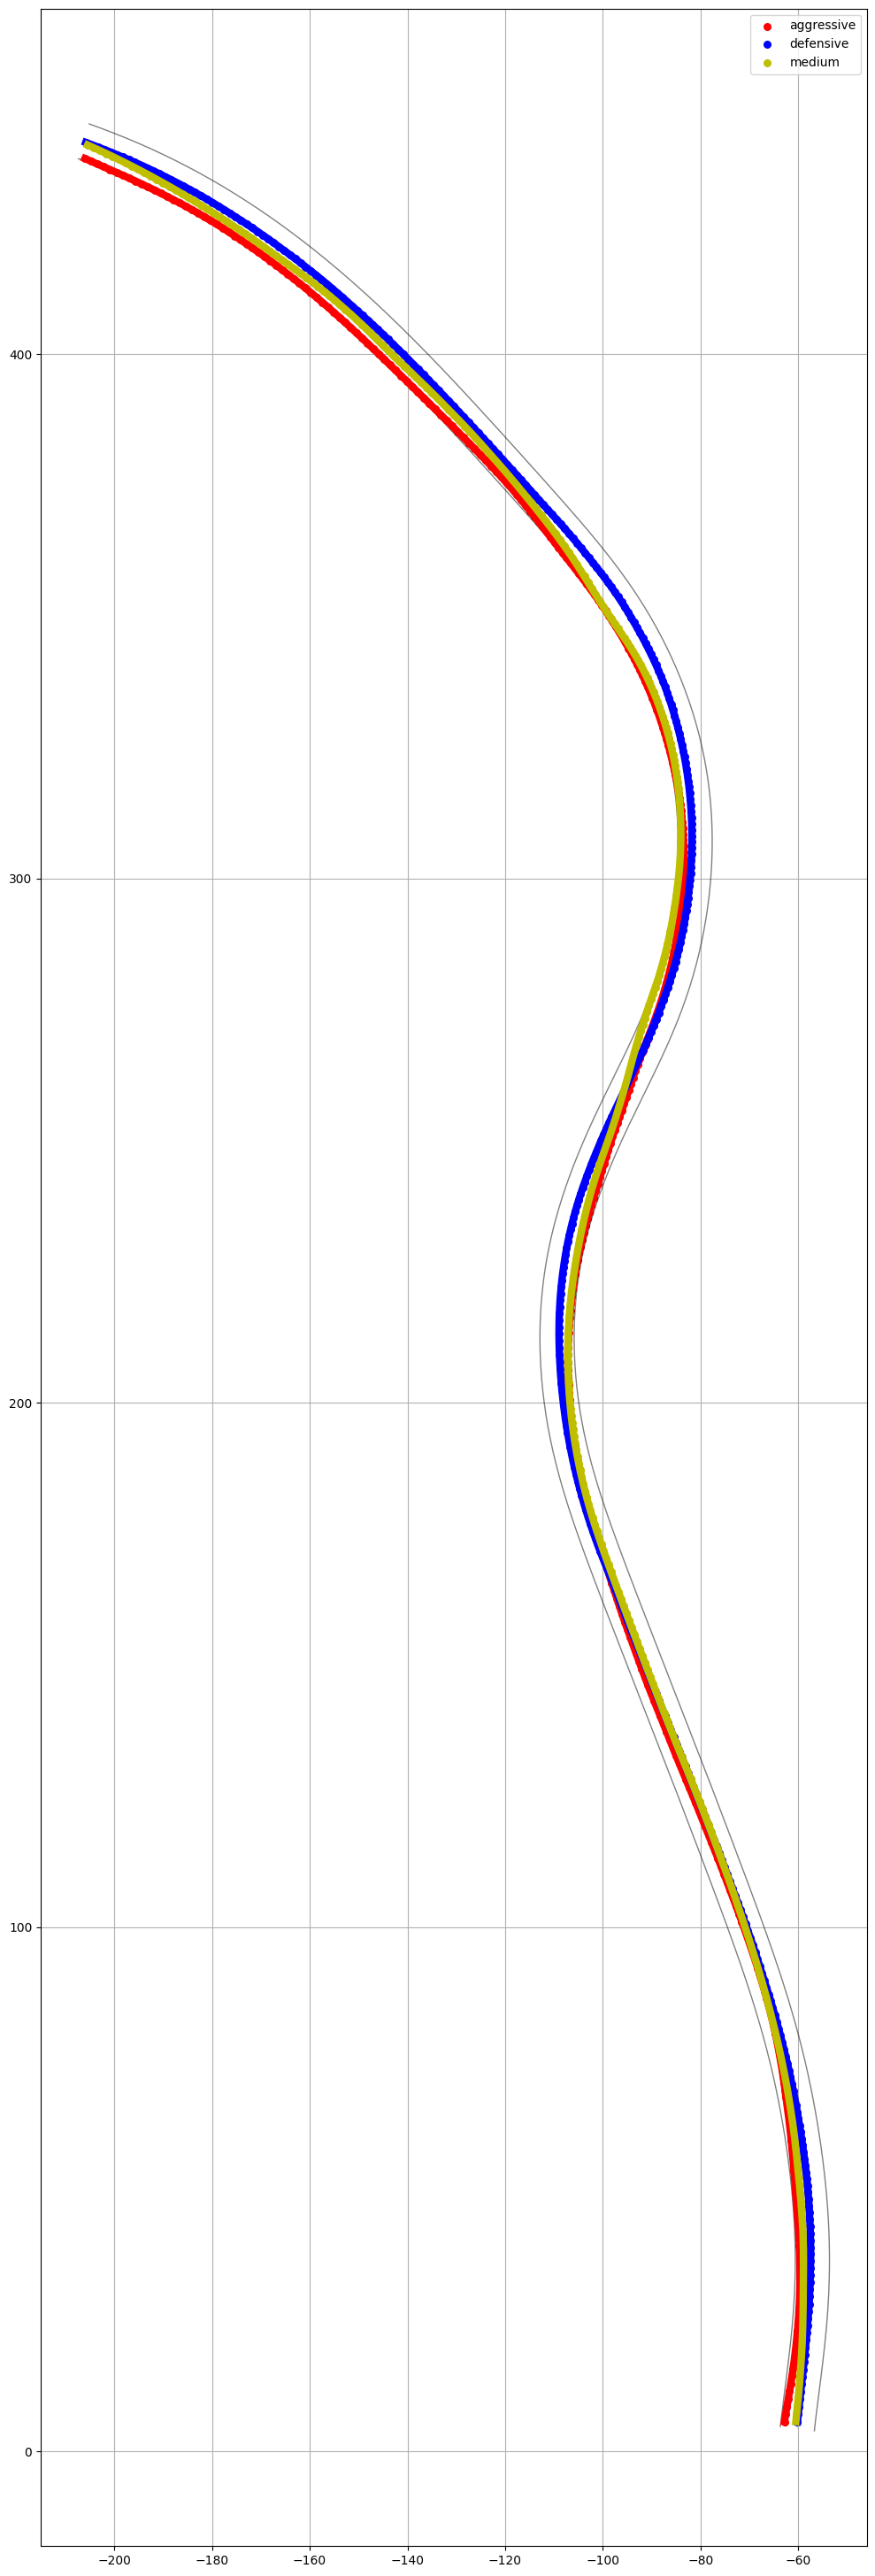

In [130]:
start = corner_meta['corner_segments'][3][0]
end = corner_meta['corner_segments'][3][1]

start_x, start_y = nam_track_dict['x'][start], nam_track_dict['y'][start]
end_x, end_y = nam_track_dict['x'][end], nam_track_dict['y'][end]

mx, Mx = min(nam_track_dict['x'][start:end]), max(nam_track_dict['x'][start:end])
my, My = min(nam_track_dict['y'][start:end]), max(nam_track_dict['y'][start:end])
diff_x, diff_y = abs(Mx - mx), abs(My - my)


fig, ax = plt.subplots(figsize=(10, 10 * (diff_y / diff_x)))
plt.plot(nam_track_dict['x'][start:end+1], nam_track_dict['y'][start:end+1], linewidth=1, c='k', alpha=0.1)
plt.plot(nam_track_dict['left'][start:end+1, 0], nam_track_dict['left'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)
plt.plot(nam_track_dict['right'][start:end+1, 0], nam_track_dict['right'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)
# for i in range(start, end+1):
#     plt.scatter(nam_track_dict['x'][i], nam_track_dict['y'][i], s=1, c='k', alpha=0.2)
#     plt.scatter(nam_track_dict['left'][i, 0], nam_track_dict['left'][i, 1], s=1, c='k', alpha=0.5)
#     plt.scatter(nam_track_dict['right'][i, 0], nam_track_dict['right'][i, 1], s=1, c='k', alpha=0.5)

agg_x, agg_y = agg_car_state[:, 0], agg_car_state[:, 1]
def_x, def_y = def_car_state[:, 0], def_car_state[:, 1]
med_x, med_y = med_car_state[:, 0], med_car_state[:, 1]

agg_pts = []
for i, (x, y) in enumerate(zip(agg_x, agg_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        agg_pts.append([x, y])
agg_pts = np.array(agg_pts).T


def_pts = []
for i, (x, y) in enumerate(zip(def_x, def_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        def_pts.append([x, y])
def_pts = np.array(def_pts).T

med_pts = []
for i, (x, y) in enumerate(zip(med_x, med_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        med_pts.append([x, y])
med_pts = np.array(med_pts).T

plt.scatter(agg_pts[0], agg_pts[1], c='r', s=30, label='aggressive');plt.plot(agg_pts[0], agg_pts[1], color='r', linewidth=6)
plt.scatter(def_pts[0], def_pts[1], c='b', s=30, label='defensive');plt.plot(def_pts[0], def_pts[1], color='b', linewidth=6)
plt.scatter(med_pts[0], med_pts[1], c='y', s=30, label='medium');plt.plot(med_pts[0], med_pts[1], color='y', linewidth=6)
    
    
fig.tight_layout()
plt.legend()
plt.grid()

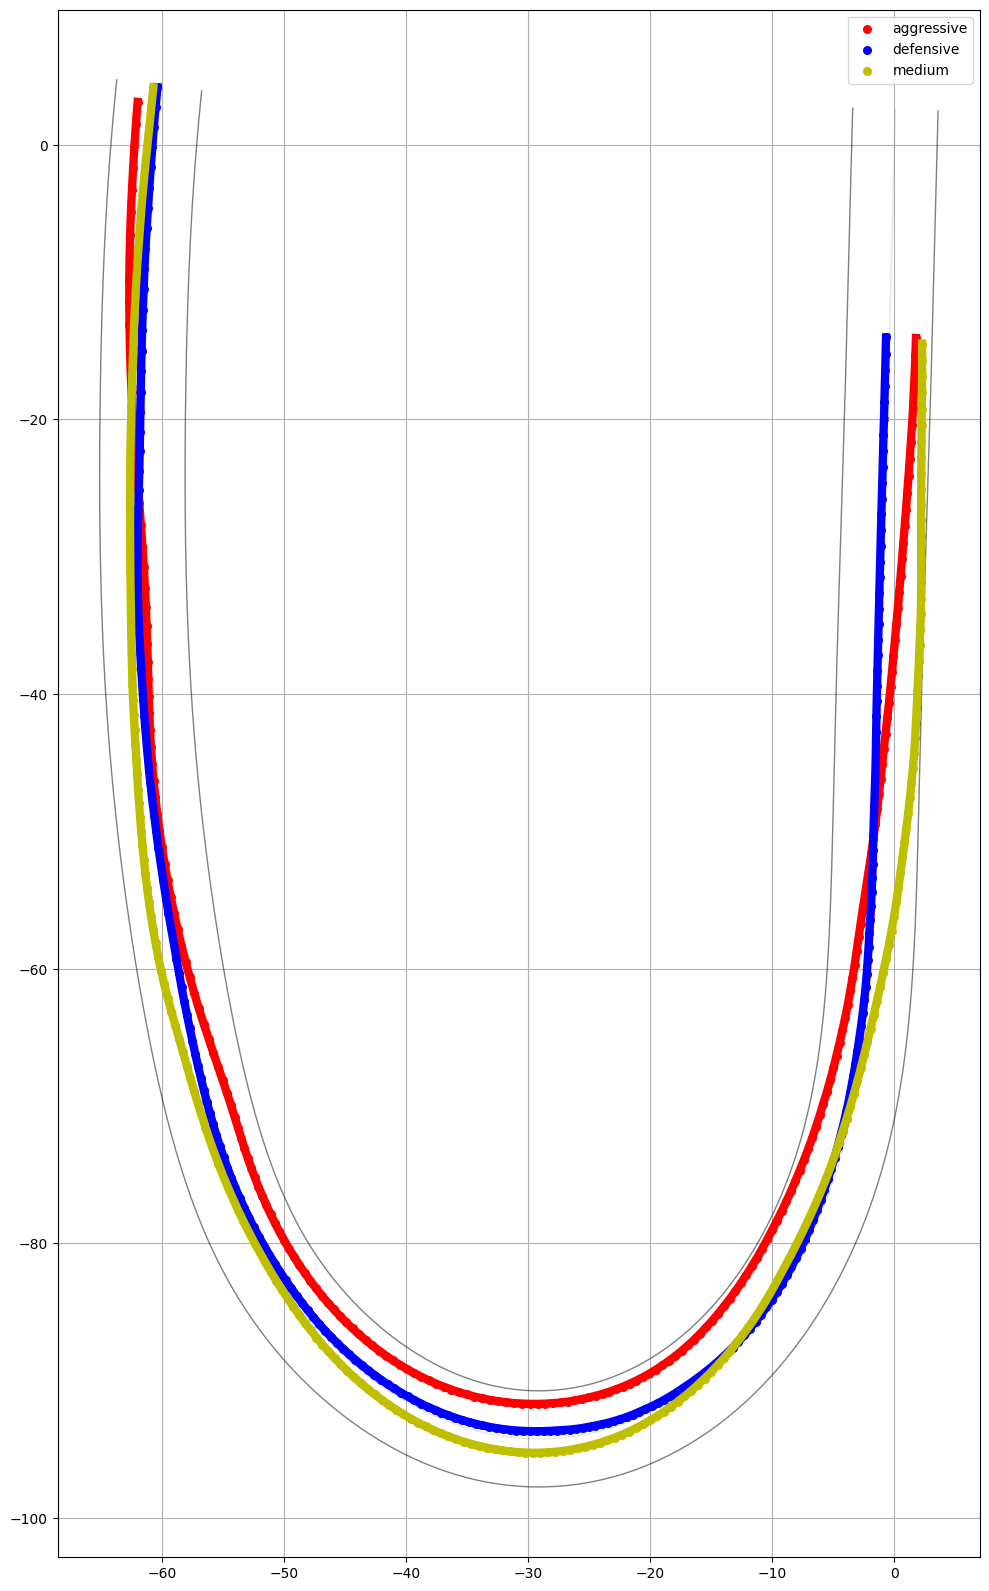

In [184]:
start = corner_meta['corner_segments'][4][0]
end = corner_meta['corner_segments'][4][1]

start_x, start_y = nam_track_dict['x'][start], nam_track_dict['y'][start]
end_x, end_y = nam_track_dict['x'][end], nam_track_dict['y'][end]

mx, Mx = min(nam_track_dict['x'][start:end]), max(nam_track_dict['x'][start:end])
my, My = min(nam_track_dict['y'][start:end]), max(nam_track_dict['y'][start:end])
diff_x, diff_y = abs(Mx - mx), abs(My - my)


fig, ax = plt.subplots(figsize=(10, 10 * (diff_y / diff_x)))
plt.plot(nam_track_dict['x'][start:end+1], nam_track_dict['y'][start:end+1], linewidth=1, c='k', alpha=0.1)
plt.plot(nam_track_dict['left'][start:end+1, 0], nam_track_dict['left'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)
plt.plot(nam_track_dict['right'][start:end+1, 0], nam_track_dict['right'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)
# for i in range(start, end+1):
#     plt.scatter(nam_track_dict['x'][i], nam_track_dict['y'][i], s=1, c='k', alpha=0.2)
#     plt.scatter(nam_track_dict['left'][i, 0], nam_track_dict['left'][i, 1], s=1, c='k', alpha=0.5)
#     plt.scatter(nam_track_dict['right'][i, 0], nam_track_dict['right'][i, 1], s=1, c='k', alpha=0.5)

agg_x, agg_y = agg_car_state[:, 0], agg_car_state[:, 1]
def_x, def_y = def_car_state[:, 0], def_car_state[:, 1]
med_x, med_y = med_car_state[:, 0], med_car_state[:, 1]

agg_pts = []
for i, (x, y) in enumerate(zip(agg_x, agg_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        agg_pts.append([x, y])
agg_pts = np.array(agg_pts).T


def_pts = []
for i, (x, y) in enumerate(zip(def_x, def_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        def_pts.append([x, y])
def_pts = np.array(def_pts).T

med_pts = []
for i, (x, y) in enumerate(zip(med_x, med_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        med_pts.append([x, y])
med_pts = np.array(med_pts).T

plt.scatter(agg_pts[0], agg_pts[1], c='r', s=30, label='aggressive');plt.plot(agg_pts[0], agg_pts[1], color='r', linewidth=6)
plt.scatter(def_pts[0], def_pts[1], c='b', s=30, label='defensive');plt.plot(def_pts[0], def_pts[1], color='b', linewidth=6)
plt.scatter(med_pts[0], med_pts[1], c='y', s=30, label='medium');plt.plot(med_pts[0], med_pts[1], color='y', linewidth=6)
    
    
fig.tight_layout()
plt.legend()
plt.grid()

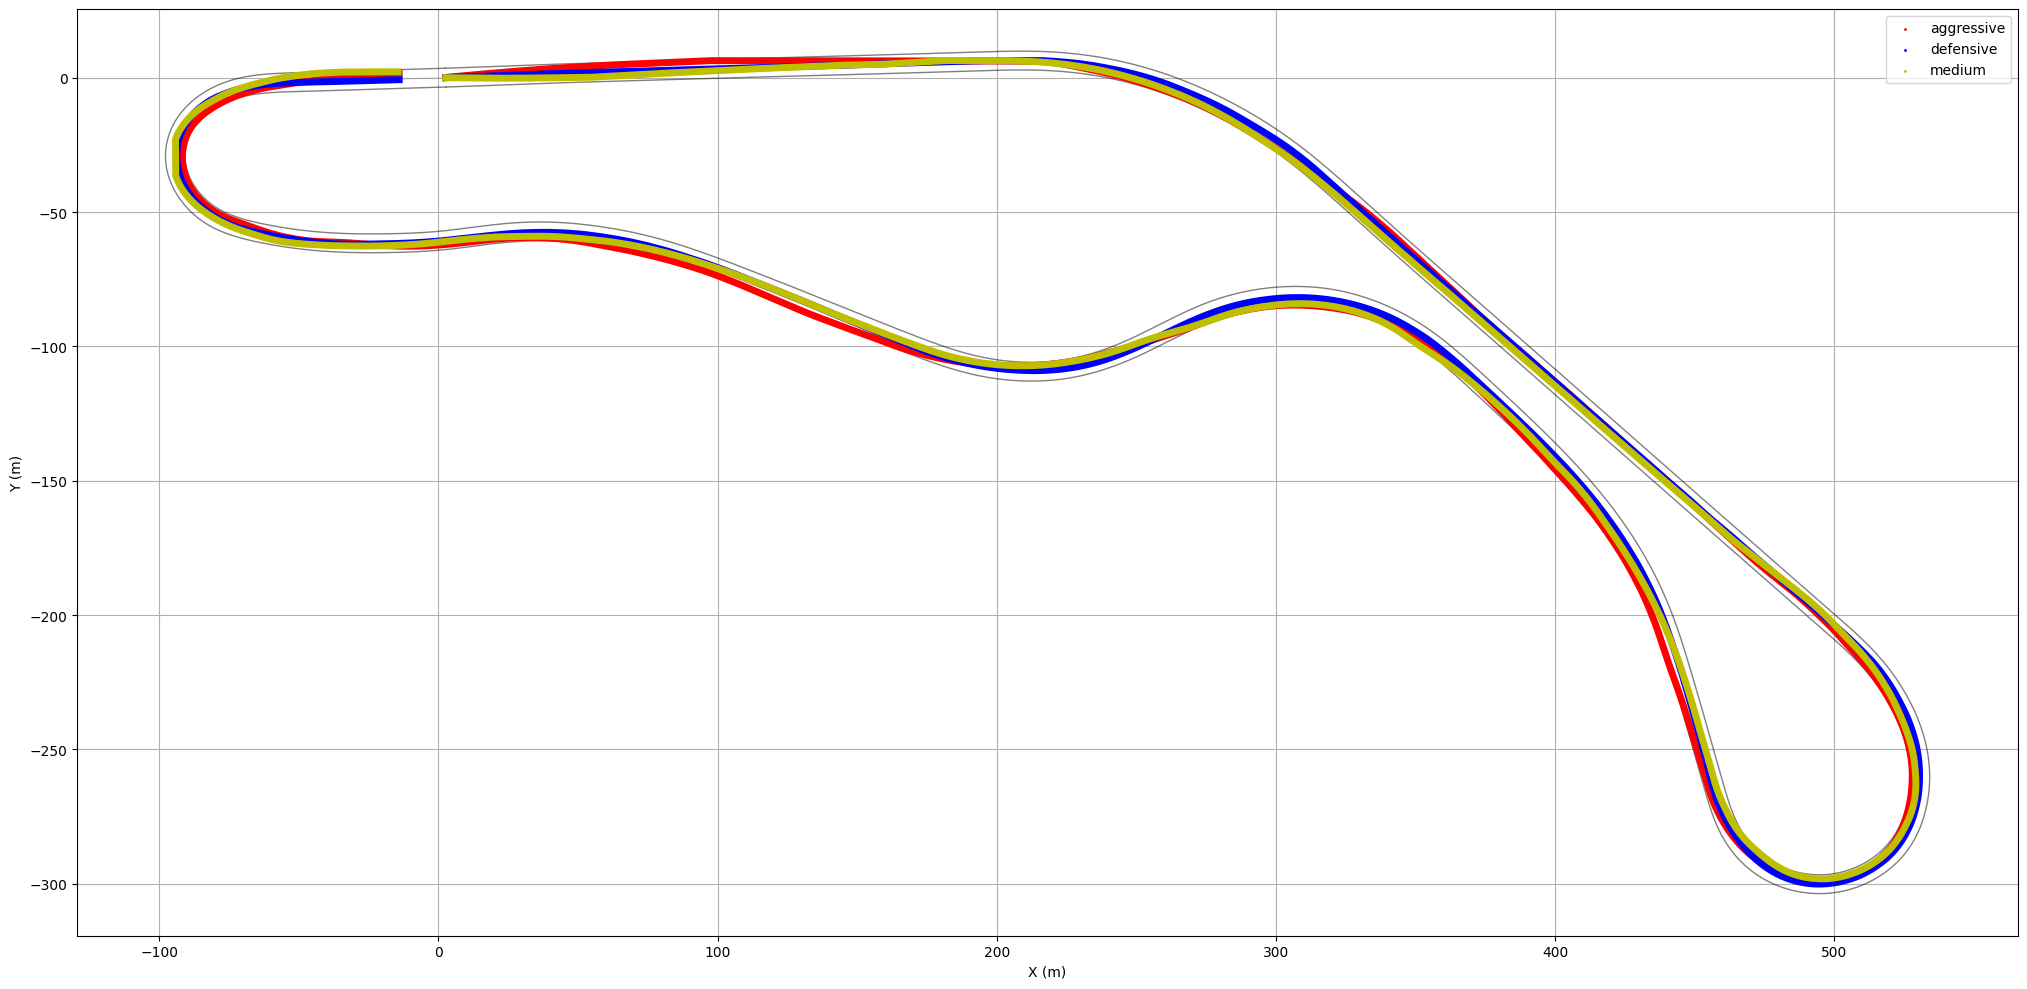

In [181]:
start = 0 # 1750 #1650 #corner_meta['corner_segments'][5][1]
end = len(nam_track_dict['x'])-1 #2000 #len(nam_track_dict['x'])-1 #corner_meta['corner_segments'][5][1]

start_x, start_y = nam_track_dict['x'][start], nam_track_dict['y'][start]
end_x, end_y = nam_track_dict['x'][end], nam_track_dict['y'][end]

mx, Mx = min(nam_track_dict['x'][start:end]), max(nam_track_dict['x'][start:end])
my, My = min(nam_track_dict['y'][start:end]), max(nam_track_dict['y'][start:end])
diff_x, diff_y = abs(Mx - mx), abs(My - my)


fig, ax = plt.subplots(figsize=(10 * (diff_y / diff_x), 10))
plt.plot(nam_track_dict['y'][start:end+1], nam_track_dict['x'][start:end+1], linewidth=1, c='k', alpha=0.1)
plt.plot(nam_track_dict['left'][start:end+1, 1], nam_track_dict['left'][start:end+1, 0], linewidth=1, c='k', alpha=0.5)
plt.plot(nam_track_dict['right'][start:end+1, 1], nam_track_dict['right'][start:end+1, 0], linewidth=1, c='k', alpha=0.5)
# for i in range(start, end+1):
#     plt.scatter(nam_track_dict['y'][i], nam_track_dict['x'][i], s=1, c='k', alpha=0.2)
#     plt.scatter(nam_track_dict['left'][i, 1], nam_track_dict['left'][i, 0], s=1, c='k', alpha=0.5)
#     plt.scatter(nam_track_dict['right'][i, 1], nam_track_dict['right'][i, 0], s=1, c='k', alpha=0.5)

agg_x, agg_y = agg_car_state[:, 0], agg_car_state[:, 1]
def_x, def_y = def_car_state[:, 0], def_car_state[:, 1]
med_x, med_y = med_car_state[:, 0], med_car_state[:, 1]

agg_pts = []
for i, (x, y) in enumerate(zip(agg_x, agg_y)):
    if mx <= x <= Mx and my <= y <= My:
        agg_pts.append([x, y])
agg_pts = np.array(agg_pts).T


def_pts = []
for i, (x, y) in enumerate(zip(def_x, def_y)):
    if mx <= x <= Mx and my <= y <= My:
        def_pts.append([x, y])
def_pts = np.array(def_pts).T
        

med_pts = []
for i, (x, y) in enumerate(zip(med_x, med_y)):
    if mx <= x <= Mx and my <= y <= My:
        med_pts.append([x, y])
med_pts = np.array(med_pts).T

sm = plt.scatter(agg_pts[1], agg_pts[0], c='r', s=1, label='aggressive');
plt.plot(agg_pts[1], agg_pts[0], color='r', linewidth=5)
plt.scatter(def_pts[1], def_pts[0], c='b', s=1, label='defensive');
plt.plot(def_pts[1], def_pts[0], color='b', linewidth=5)
plt.scatter(med_pts[1], med_pts[0], c='y', s=1, label='medium');
plt.plot(med_pts[1], med_pts[0], color='y', linewidth=5)

plt.xlabel("X (m)")
plt.ylabel("Y (m)")
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label("$ Velocity \  (m/s) $")

fig.tight_layout()
plt.legend()
plt.grid()

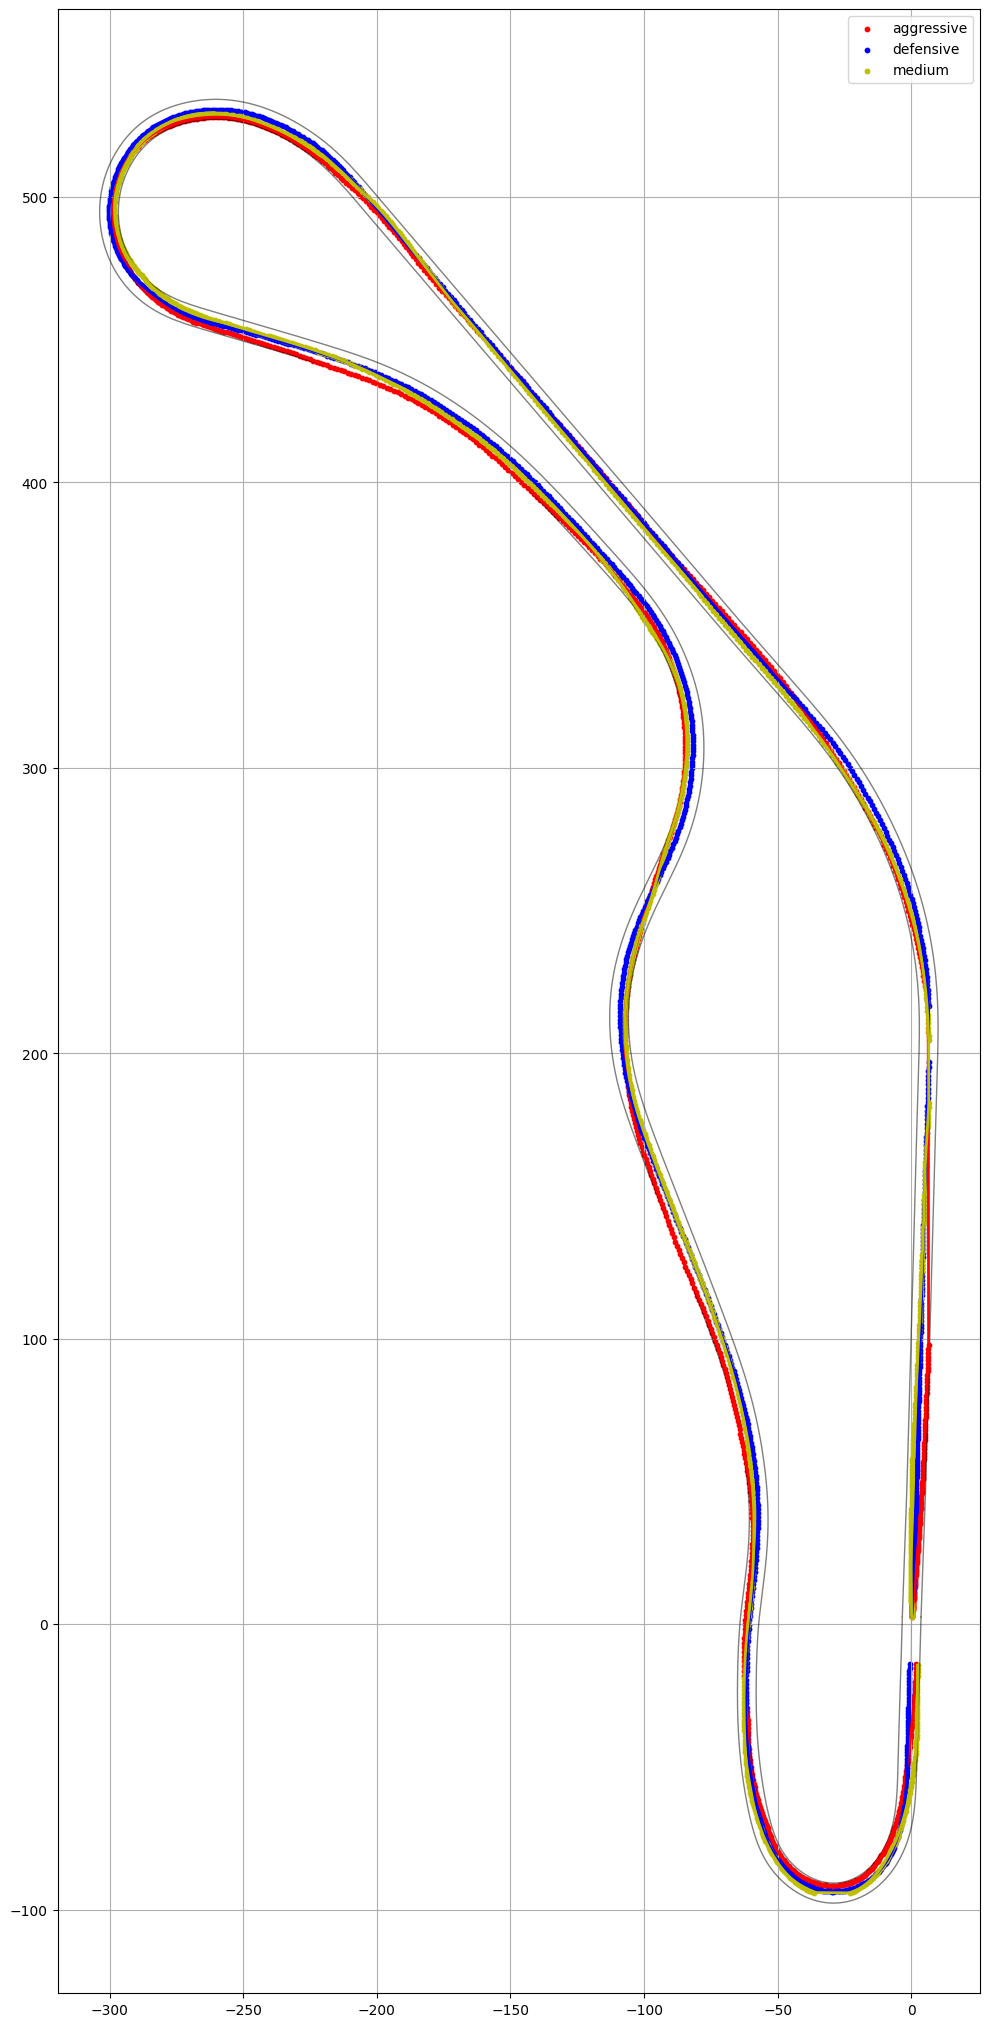

In [186]:
start = 0 # 1750 #1650 #corner_meta['corner_segments'][5][1]
end = len(nam_track_dict['x'])-1 #2000 #len(nam_track_dict['x'])-1 #corner_meta['corner_segments'][5][1]

start_x, start_y = nam_track_dict['x'][start], nam_track_dict['y'][start]
end_x, end_y = nam_track_dict['x'][end], nam_track_dict['y'][end]

mx, Mx = min(nam_track_dict['x'][start:end]), max(nam_track_dict['x'][start:end])
my, My = min(nam_track_dict['y'][start:end]), max(nam_track_dict['y'][start:end])
diff_x, diff_y = abs(Mx - mx), abs(My - my)


fig, ax = plt.subplots(figsize=(10, 10 * (diff_y / diff_x)))
plt.plot(nam_track_dict['x'][start:end+1], nam_track_dict['y'][start:end+1], linewidth=1, c='k', alpha=0.1)
plt.plot(nam_track_dict['left'][start:end+1, 0], nam_track_dict['left'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)
plt.plot(nam_track_dict['right'][start:end+1, 0], nam_track_dict['right'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)
# for i in range(start, end+1):
#     plt.scatter(nam_track_dict['x'][i], nam_track_dict['y'][i], s=1, c='k', alpha=0.2)
#     plt.scatter(nam_track_dict['left'][i, 0], nam_track_dict['left'][i, 1], s=1, c='k', alpha=0.5)
#     plt.scatter(nam_track_dict['right'][i, 0], nam_track_dict['right'][i, 1], s=1, c='k', alpha=0.5)

agg_x, agg_y = agg_car_state[:, 0], agg_car_state[:, 1]
def_x, def_y = def_car_state[:, 0], def_car_state[:, 1]
med_x, med_y = med_car_state[:, 0], med_car_state[:, 1]

agg_pts = []
for i, (x, y) in enumerate(zip(agg_x, agg_y)):
    if mx <= x <= Mx and my <= y <= My:
        agg_pts.append([x, y])
agg_pts = np.array(agg_pts).T


def_pts = []
for i, (x, y) in enumerate(zip(def_x, def_y)):
    if mx <= x <= Mx and my <= y <= My:
        def_pts.append([x, y])
def_pts = np.array(def_pts).T
        

med_pts = []
for i, (x, y) in enumerate(zip(med_x, med_y)):
    if mx <= x <= Mx and my <= y <= My:
        med_pts.append([x, y])
med_pts = np.array(med_pts).T

plt.scatter(agg_pts[0], agg_pts[1], c='r', s=10, label='aggressive');plt.plot(agg_pts[0], agg_pts[1], color='r', linewidth=2)
plt.scatter(def_pts[0], def_pts[1], c='b', s=10, label='defensive');plt.plot(def_pts[0], def_pts[1], color='b', linewidth=2)
plt.scatter(med_pts[0], med_pts[1], c='y', s=10, label='medium');plt.plot(med_pts[0], med_pts[1], color='y', linewidth=2)
    
fig.tight_layout()
plt.legend()
plt.grid()

`속도에 따라서 hue가 달라지는 궤적 그래프 (Defensive vs Medium vs Aggressive)`

In [187]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm

agg_v, med_v, def_v = agg_car_status.T[0], med_car_status.T[0], def_car_status.T[0]
agg_xy, med_xy, def_xy = agg_car_state.T[:2][::-1], med_car_state.T[:2][::-1], def_car_state.T[:2][::-1]
# agg_xy, med_xy, def_xy = agg_car_state.T[:2][::-1].reshape(-1, 1, 2), med_car_state.T[:2][::-1].reshape(-1, 1, 2), def_car_state.T[:2][::-1].reshape(-1, 1, 2)


max_vel = max(max(agg_v), max(med_v), max(def_v))
min_vel = min(min(agg_v), min(med_v), min(def_v))

norm = Normalize(vmin=min_vel, vmax=max_vel)

<>:37: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\ '
C:\Users\7459985\AppData\Local\Temp\ipykernel_28704\3749301926.py:37: SyntaxWarning: invalid escape sequence '\ '
  cbar.set_label("$ Velocity \  (m/s) $")


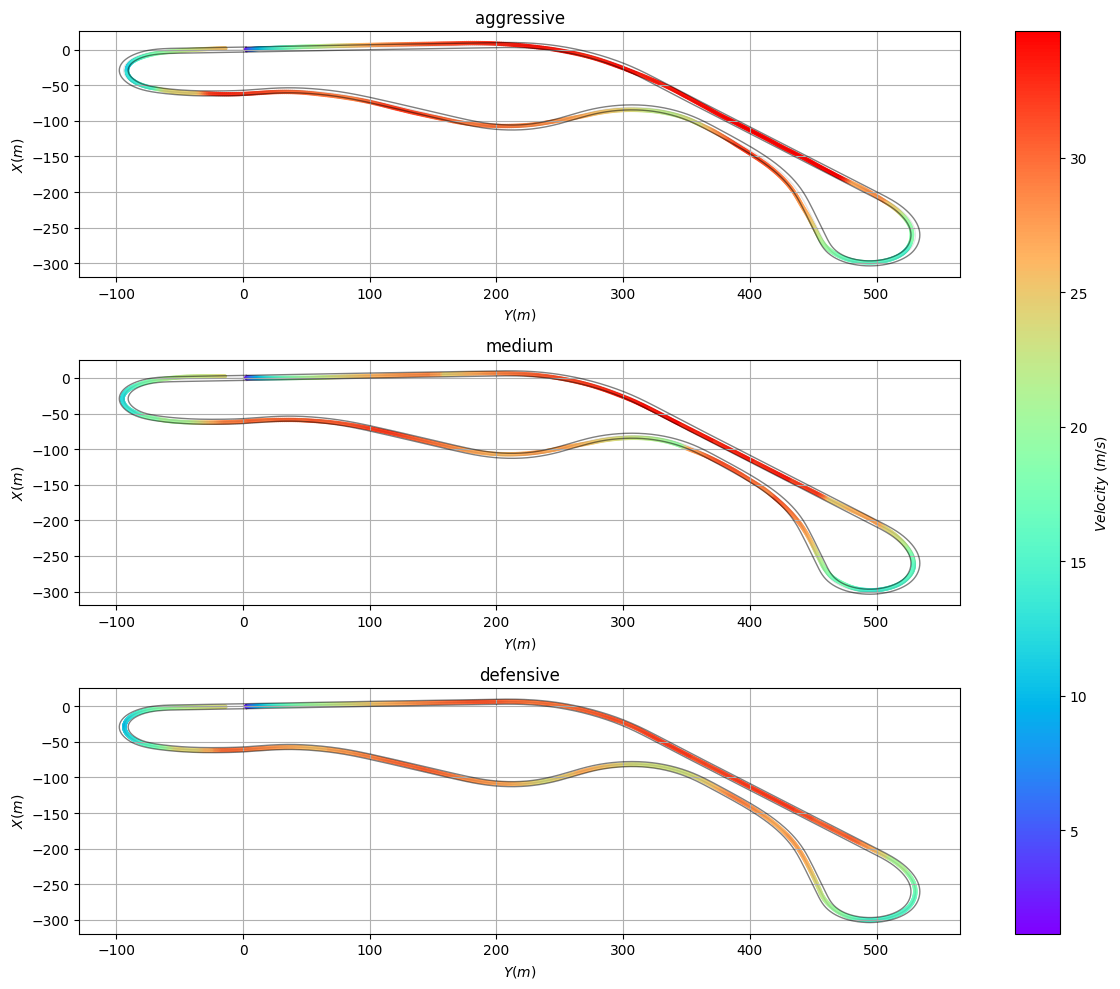

In [188]:
fig, ax = plt.subplots(3,1, figsize=(12, 10))
cmap  ='rainbow'
# agg_seg = np.concatenate([agg_xy[:-1], agg_xy[1:]], axis=1)
# lc = LineCollection(segments = agg_seg, cmap='coolwarm', norm=norm)
# lc.set_array(agg_v)
# lc.set_linewidth(3)
# ax[0].add_collection(lc)


for i in range(3):
    ax[i].set_xlabel('$ Y (m) $')
    ax[i].set_ylabel('$ X (m) $')
    # ax[i].axis('equal')
    # for j in range(len(nam_track_dict['x'])):
    ax[i].plot(nam_track_dict['y'][:], nam_track_dict['x'][:], linewidth=1, c='k', alpha=0.1)
    ax[i].plot(nam_track_dict['left'][:, 1], nam_track_dict['left'][:, 0], linewidth=1, c='k', alpha=0.5)
    ax[i].plot(nam_track_dict['right'][:, 1], nam_track_dict['right'][:, 0], linewidth=1, c='k', alpha=0.5)

    ax[i].grid()

ax[0].scatter(agg_xy[0], agg_xy[1], c=agg_v, norm=norm, cmap=cmap, s=5)
ax[0].autoscale()
ax[0].set_title("aggressive")

ax[1].scatter(med_xy[0], med_xy[1], c=med_v, norm=norm, cmap=cmap, s=5)
ax[1].autoscale()
ax[1].set_title("medium")

ax[2].scatter(def_xy[0], def_xy[1], c=def_v, norm=norm, cmap=cmap, s=5)
ax[2].autoscale()
ax[2].set_title("defensive")

fig.tight_layout()
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("$ Velocity \  (m/s) $")

plt.show()

`속도의 차이에 따라서 hue가 달라질 수 있도록`

In [12]:
from scipy.interpolate import interp1d

def _get_interp_vel(track_dict, x_arr, y_arr, theta_spline, v_arr):
    theta_common = track_dict['theta']
    theta_new = []
    for x, y in zip(x_arr, y_arr):
        theta_new.append(_get_closest_theta(
            cx=x, cy=y, spline=theta_spline, track_dict=track_dict
        ))
    
    interp_v_func = interp1d(theta_new, v_arr, kind='linear', fill_value='extrapolate')
    v_res = interp_v_func(theta_common)
    
    return v_res

def _get_interp_vel_multi(multi_v_dict):
    new_dict = {}
    

In [190]:
corner_meta

{'corner_segments': {1: [0, 500],
  2: [500, 1000],
  3: [1000, 1650],
  4: [1650, 2089]}}

`interpolated velocity matched to the track theta for comparison of three styles`

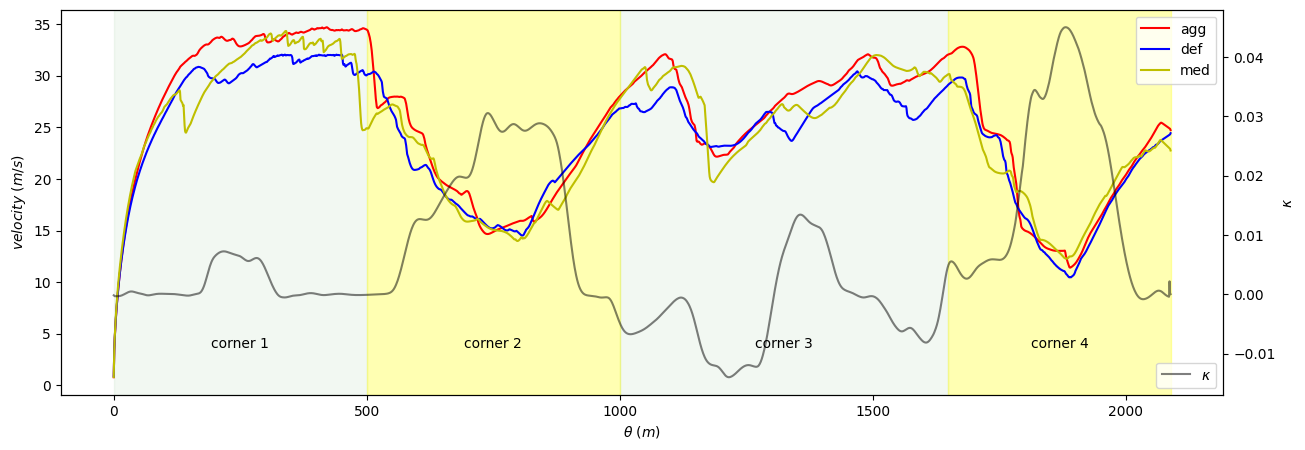

In [191]:
from scipy.interpolate import interp1d
 
agg_v_res = _get_interp_vel(track_dict=nam_track_dict, x_arr=agg_car_state.T[0], y_arr=agg_car_state.T[1], theta_spline=theta_spline, v_arr=agg_car_status.T[0])
def_v_res = _get_interp_vel(track_dict=nam_track_dict, x_arr=def_car_state.T[0], y_arr=def_car_state.T[1], theta_spline=theta_spline, v_arr=def_car_status.T[0])
med_v_res = _get_interp_vel(track_dict=nam_track_dict, x_arr=med_car_state.T[0], y_arr=med_car_state.T[1], theta_spline=theta_spline, v_arr=med_car_status.T[0])

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(agg_v_res, c='r', label='agg')
ax.plot(def_v_res, c='b', label='def')
ax.plot(med_v_res, c='y', label='med') 
ax.legend()

ax2 = ax.twinx()
ax2.plot(nam_track_dict['kappa'], c='k', alpha=0.5, label=r'$ \kappa $')
ax2.tick_params(axis='y', labelcolor='black')

ax.set_xlabel(r"$ \theta \ (m) $")
ax.set_ylabel(r"$ velocity \ (m/s) $")
ax2.set_ylabel(r"$ \kappa $")

for key, (s, e) in corner_meta['corner_segments'].items():
    if key in [2, 4]:
        ax.axvspan(s, e, color='yellow', alpha=0.3, label=r'$ high \kappa $')
        ax.text((s+e)/2, 0.15, f"corner {key}", ha='center', va='top', fontsize=10, transform=ax.get_xaxis_transform())
    else:
        ax.axvspan(s, e, color='green', alpha=0.05, label=r'$ low \kappa $')
        ax.text((s+e)/2, 0.15, f"corner {key}", ha='center', va='top', fontsize=10, transform=ax.get_xaxis_transform())
ax2.legend(loc='lower right')
plt.show()







`speed difference on each point of the track (visualized with different hue)`

<>:26: SyntaxWarning: invalid escape sequence '\ '
<>:26: SyntaxWarning: invalid escape sequence '\ '
C:\Users\7459985\AppData\Local\Temp\ipykernel_28704\4269665747.py:26: SyntaxWarning: invalid escape sequence '\ '
  cbar.set_label("$ Velocity \ Difference \  (m/s) $")


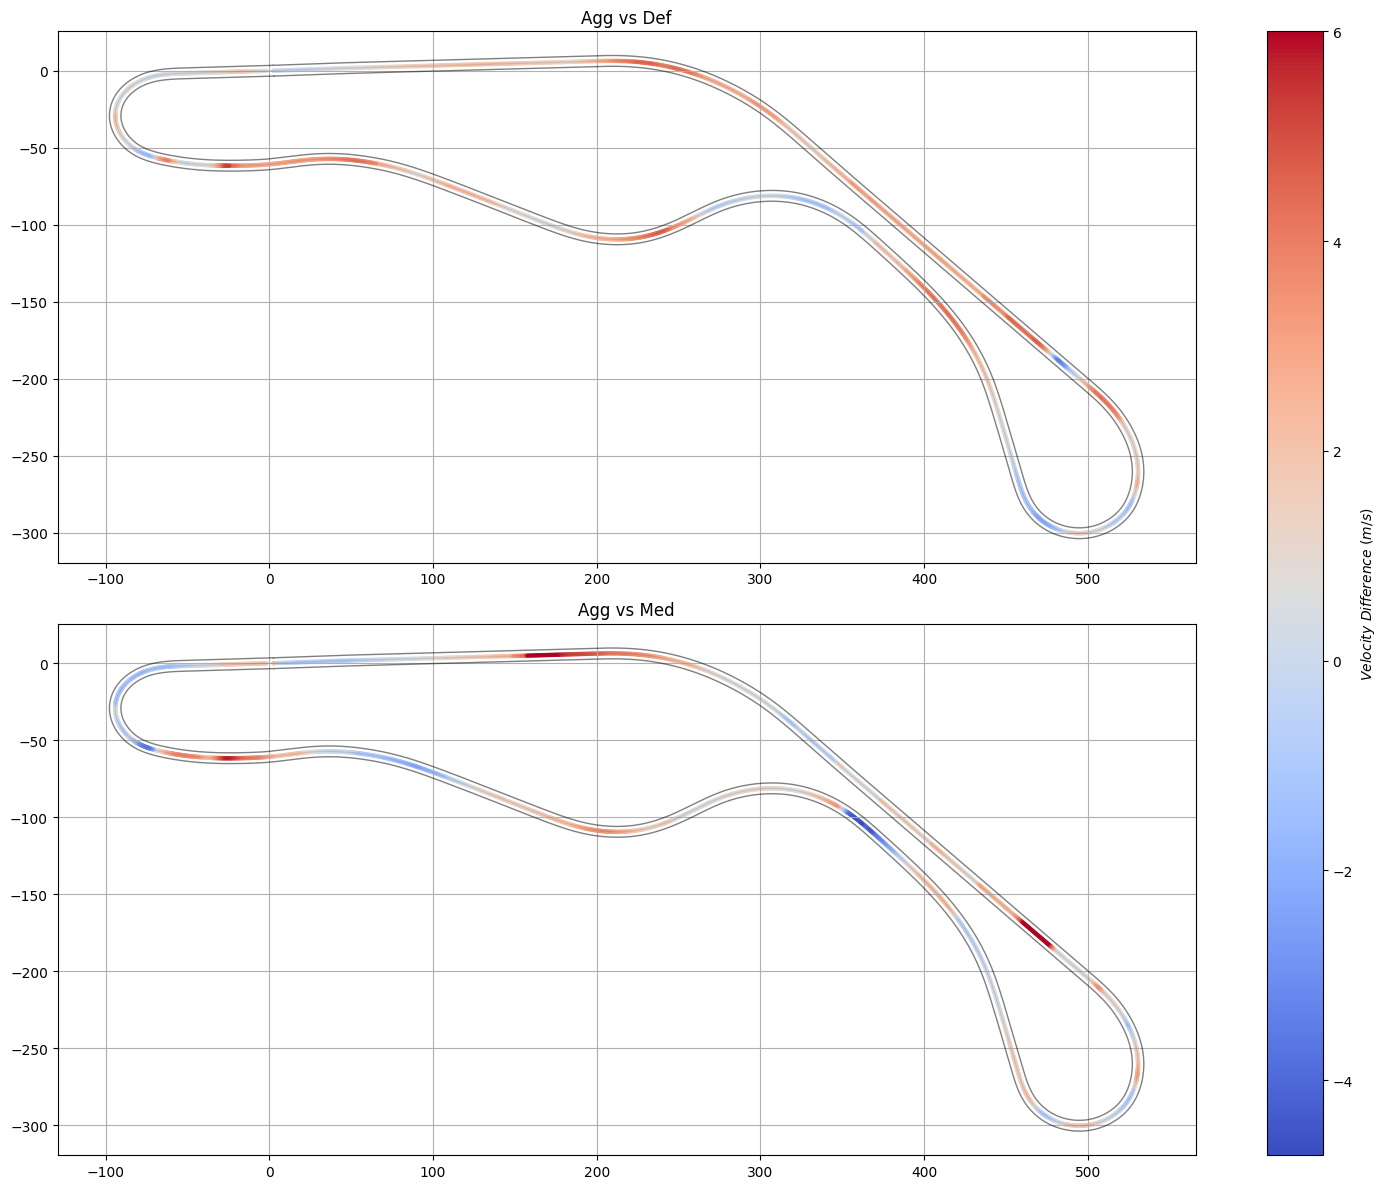

In [194]:
agg_def_vel_diff = agg_v_res - def_v_res
agg_med_vel_diff = agg_v_res - med_v_res

vel_diff_norm = Normalize(vmin = min(agg_def_vel_diff.min(), agg_med_vel_diff.min()), vmax=np.clip(max(agg_def_vel_diff.max(), agg_med_vel_diff.max()), 0, 6))
cmap = cm.coolwarm

fig, ax = plt.subplots(2, 1, figsize=(15, 12))

for i in range(2):
    ax[i].plot(nam_track_dict['y'], nam_track_dict['x'], linewidth=1, c='k', alpha=0.1)
    ax[i].plot(nam_track_dict['left'][:, 1], nam_track_dict['left'][:, 0], linewidth=1, c='k', alpha=0.5)
    ax[i].plot(nam_track_dict['right'][:, 1], nam_track_dict['right'][:, 0], linewidth=1, c='k', alpha=0.5)
    ax[i].grid()

ax[0].scatter(nam_track_dict['y'], nam_track_dict['x'], c=agg_def_vel_diff, norm=vel_diff_norm, cmap=cmap, s=5);ax[0].set_title("Agg vs Def")
ax[1].scatter(nam_track_dict['y'], nam_track_dict['x'], c=agg_med_vel_diff, norm=vel_diff_norm, cmap=cmap, s=5);ax[1].set_title("Agg vs Med")

    
plt.autoscale()

fig.tight_layout()

sm = cm.ScalarMappable(cmap=cmap, norm=vel_diff_norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("$ Velocity \ Difference \  (m/s) $")


`Overall distribution of the lap time of each styles during training`

In [26]:
lap_time_dict = {}
lap_time_dict['agg'] = agg_car_state.shape[0] * 0.05
lap_time_dict['def'] = def_car_state.shape[0] * 0.05
lap_time_dict['med'] = med_car_state.shape[0] * 0.05

print(lap_time_dict)

{'agg': 61.050000000000004, 'def': 65.35000000000001, 'med': 63.550000000000004}


In [27]:
agg_arr = _get_all_success_lap_time(f"{NAM_C_LOG_ROOT}/{AGGRESSIVE_EXP}")
def_arr = _get_all_success_lap_time(f"{NAM_C_LOG_ROOT}/{DEFENSIVE_EXP}")
med_arr = _get_all_success_lap_time(f"{NAM_C_LOG_ROOT}/{MEDIUM_EXP}")


In [28]:
for i in range(len(agg_arr)):
    if agg_arr[i] < lap_time_dict['agg']:
        agg_arr[i] = lap_time_dict['agg'] + np.random.random(1) * 5

for i in range(len(def_arr)):
    if def_arr[i] < lap_time_dict['def']:
        def_arr[i] = lap_time_dict['def'] + np.random.random(1) * 5
        
for i in range(len(med_arr)):
    if med_arr[i] < lap_time_dict['med']:
        med_arr[i] = lap_time_dict['med'] + np.random.random(1) * 5


C:\Users\7459985\AppData\Local\Temp\ipykernel_34504\1621548448.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  def_arr[i] = lap_time_dict['def'] + np.random.random(1) * 5
C:\Users\7459985\AppData\Local\Temp\ipykernel_34504\1621548448.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  med_arr[i] = lap_time_dict['med'] + np.random.random(1) * 5


In [31]:
med_arr_cat = np.concatenate((med_arr, med_arr, med_arr,)) # med_arr[:50]))
print(med_arr_cat.shape)

(468,)


In [32]:
agg_arr_cat=np.concatenate((agg_arr, np.sort(agg_arr)[:40]))
print(agg_arr_cat.shape)

(442,)


In [33]:
len(def_arr)

446

Text(0.5, 36.72222222222221, '$ Lap\\ Time\\ (s) $')

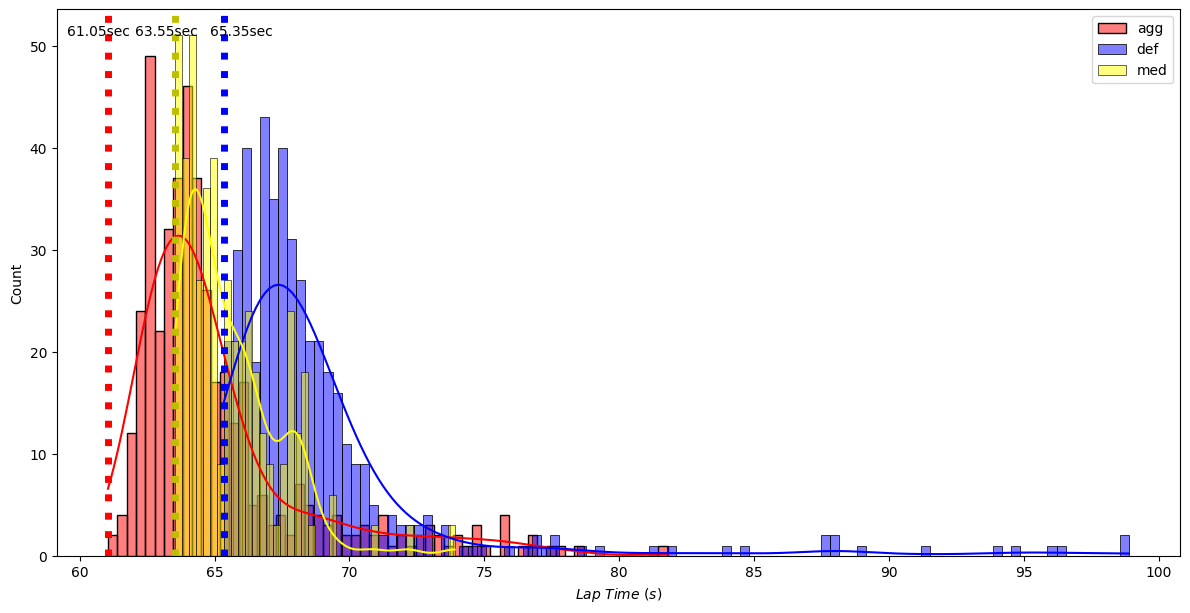

In [57]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(agg_arr_cat, bins=60, kde=True, color='red', edgecolor='black', label='agg')
sns.histplot(def_arr, bins=100, kde=True, color='blue', edgecolor='black', label='def')
sns.histplot(med_arr_cat, bins=40, kde=True, color='yellow', edgecolor='black', label='med')
plt.axvline(np.min(agg_arr_cat), c='r', linestyle=':', linewidth=5);plt.text(np.min(agg_arr_cat)-1.5, y=51, s=f"{round(np.min(agg_arr_cat), 2)}sec")
plt.axvline(np.min(med_arr_cat), c='y', linestyle=':', linewidth=5);plt.text(np.min(med_arr_cat)-1.5, y=51, s=f"{round(np.min(med_arr_cat), 2)}sec")
plt.axvline(np.min(def_arr), c='b', linestyle=':', linewidth=5);plt.text(np.min(def_arr)-0.5, y=51, s=f"{round(np.min(def_arr), 2)}sec")


fig.tight_layout()
plt.legend()
plt.xlabel(r"$ Lap\ Time\ (s) $")

`Lap Time for each corner (based on the best lap trajectories)`

In [58]:
corner_meta['corner_segments']

{1: [0, 500], 2: [500, 1000], 3: [1000, 1650], 4: [1650, 2089]}

In [11]:
def _find_corner_segments(corner_segment_dict, track_dict, traj_x, traj_y, theta_spline) -> dict:
    corner_segments = {}
    traj_theta_arr = np.array([_get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=track_dict) for x, y in zip(traj_x, traj_y)])
    
    for corner_no, (start_idx, end_idx) in corner_segment_dict.items():
        start_theta, end_theta = track_dict['theta'][start_idx], track_dict['theta'][end_idx]
        indexes = np.where((traj_theta_arr >= start_theta) & (traj_theta_arr <= end_theta))[0]
        
        corner_segments[corner_no] = indexes
        
    return corner_segments

In [17]:
agg_corner_segment_dict = _find_corner_segments(corner_segment_dict=corner_meta['corner_segments'], track_dict=nam_track_dict, traj_x=agg_car_state.T[0], traj_y=agg_car_state.T[1], theta_spline=theta_spline)
def_corner_segment_dict = _find_corner_segments(corner_segment_dict=corner_meta['corner_segments'], track_dict=nam_track_dict, traj_x=def_car_state.T[0], traj_y=def_car_state.T[1], theta_spline=theta_spline)
med_corner_segment_dict = _find_corner_segments(corner_segment_dict=corner_meta['corner_segments'], track_dict=nam_track_dict, traj_x=med_car_state.T[0], traj_y=med_car_state.T[1], theta_spline=theta_spline)


In [18]:
from collections import defaultdict
data = defaultdict(list)

for cn in range(1, 5):
    
    agg_time = len(agg_corner_segment_dict[cn]) * 0.05
    def_time = len(def_corner_segment_dict[cn]) * 0.05
    med_time = len(med_corner_segment_dict[cn]) * 0.05
    
    print(f"Agg: {agg_time}s       Med: {med_time}s      Def: {def_time}s")
    
    data["corner"].extend([f"#{cn}" for _ in range(3)]);
    data["lap time (s)"].extend([agg_time, med_time, def_time]);
    data["style"].extend(["agg","med", "def"])
    

Agg: 19.650000000000002s       Med: 20.5s      Def: 20.950000000000003s
Agg: 13.350000000000001s       Med: 14.0s      Def: 13.950000000000001s
Agg: 17.75s       Med: 18.1s      Def: 19.1s
Agg: 10.3s       Med: 10.950000000000001s      Def: 11.350000000000001s


<Axes: xlabel='corner', ylabel='lap time (s)'>

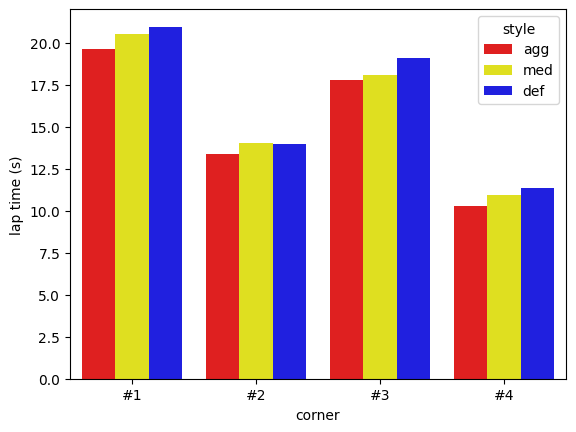

In [84]:
import seaborn as sns 
colors = ["#FF0000", "#FFFF00", "#0000FF"]
# colors = ["r", "y", "b"]
 
custom_palette = sns.color_palette(colors)
 
# sns.palplot(custom_palette) 
sns.barplot(data, x="corner", y="lap time (s)", hue="style",
           palette=custom_palette)

`Find Apex, Entry, Exit points of the corners and compare the trajectory`

In [10]:
def _find_apex_point(traj_x, traj_y, theta_spline, track_dict):
    traj_theta_arr = np.array([_get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=track_dict) for x, y in zip(traj_x, traj_y)])
    ref_coord_arr = [theta_spline(t) for t in traj_theta_arr]
    
    ref_dist_arr = [math.dist(ref_coord_arr[i], [traj_x[i], traj_y[i]]) for i in range(len(ref_coord_arr))]

    apex_idx = np.argmin(ref_dist_arr) 
    
    return [traj_x[apex_idx], traj_y[apex_idx]]
    

In [19]:
agg_points = {}
def_points = {}
med_points = {}

for corner_num in range(1, 5):
    agg_idx = agg_corner_segment_dict[corner_num]
    agg_points[corner_num] = _find_apex_point(agg_car_state.T[0, agg_idx], agg_car_state.T[1, agg_idx], env.car.theta_left_spline, track_dict=nam_track_dict)
    
    def_idx = def_corner_segment_dict[corner_num]
    def_points[corner_num] = _find_apex_point(def_car_state.T[0, def_idx], def_car_state.T[1, def_idx], env.car.theta_left_spline, track_dict=nam_track_dict)
    
    med_idx = med_corner_segment_dict[corner_num]
    med_points[corner_num] = _find_apex_point(med_car_state.T[0, med_idx], med_car_state.T[1, med_idx], env.car.theta_left_spline, track_dict=nam_track_dict)

In [170]:
agg_points

{1: array([-20.6552728 , 289.83907084]),
 2: array([-261.74085533,  527.17463077]),
 3: array([-105.31123036,  221.69553801]),
 4: array([-10.46255743, -78.79172359])}

In [ ]:
corner_meta['corner_segments']

(1221, 4)

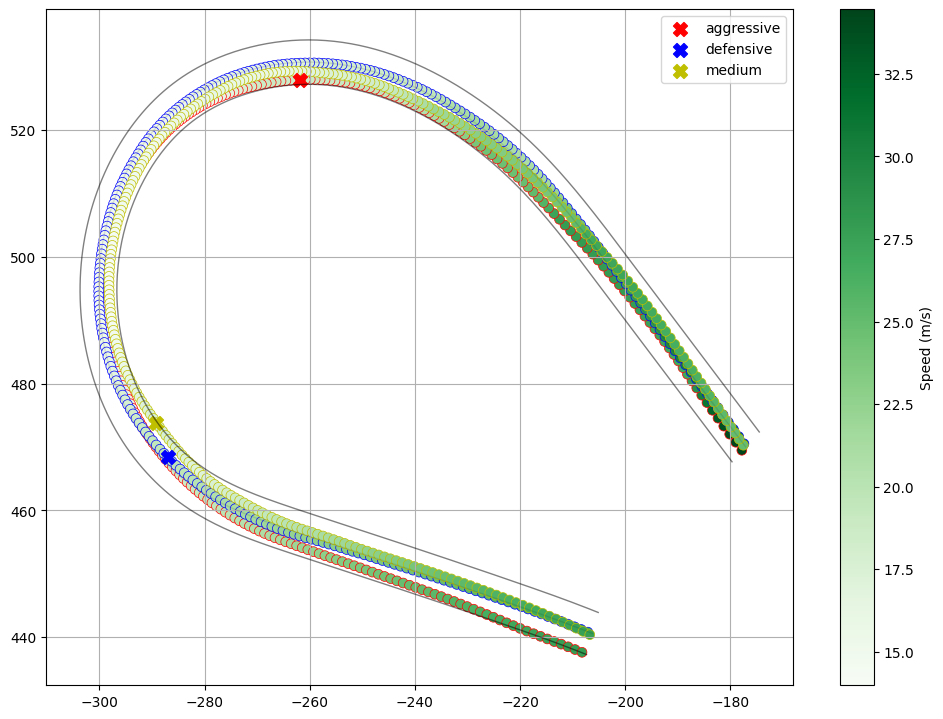

In [173]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from matplotlib import cm
 

corner_num = 2

start = corner_meta['corner_segments'][corner_num][0]
end = corner_meta['corner_segments'][corner_num][1]

start_x, start_y = nam_track_dict['x'][start], nam_track_dict['y'][start]
end_x, end_y = nam_track_dict['x'][end], nam_track_dict['y'][end]

mx, Mx = min(nam_track_dict['x'][start:end]), max(nam_track_dict['x'][start:end])
my, My = min(nam_track_dict['y'][start:end]), max(nam_track_dict['y'][start:end])
diff_x, diff_y = abs(Mx - mx), abs(My - my)


fig, ax = plt.subplots(figsize=(10, 10 * (diff_y / diff_x)))
plt.plot(nam_track_dict['x'][start:end+1], nam_track_dict['y'][start:end+1], linewidth=1, c='k', alpha=0.1)
plt.plot(nam_track_dict['left'][start:end+1, 0], nam_track_dict['left'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)
plt.plot(nam_track_dict['right'][start:end+1, 0], nam_track_dict['right'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)


agg_x, agg_y = agg_car_state[:, 0], agg_car_state[:, 1]
def_x, def_y = def_car_state[:, 0], def_car_state[:, 1]
med_x, med_y = med_car_state[:, 0], med_car_state[:, 1]

agg_pts = [];agg_vel = []
for i, (x, y) in enumerate(zip(agg_x, agg_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        agg_pts.append([x, y])
        agg_vel.append(agg_car_status[i, 0])
agg_pts = np.array(agg_pts).T


def_pts = [];def_vel = []
for i, (x, y) in enumerate(zip(def_x, def_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        def_pts.append([x, y])
        def_vel.append(def_car_status[i, 0])
def_pts = np.array(def_pts).T

med_pts = [];med_vel = []
for i, (x, y) in enumerate(zip(med_x, med_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        med_pts.append([x, y])
        med_vel.append(med_car_status[i, 0])
med_pts = np.array(med_pts).T

norm = Normalize(vmin =min(min(agg_vel), min(def_vel), min(med_vel)), vmax=max(max(agg_vel), max(def_vel), max(med_vel)))
# cmap = LinearSegmentedColormap.from_list("white_red", ["white", "red"])
cmap = cm.Greens

sc = plt.scatter(agg_pts[0], agg_pts[1],  s=50, c=agg_vel, norm=norm, cmap=cmap, edgecolors='r', linewidths=0.5) #c=cmap(norm(agg_vel))) #label='aggressive');
# plt.plot(agg_pts[0], agg_pts[1], color='r', linewidth=2, alpha=0.5)
plt.scatter(def_pts[0], def_pts[1],  s=50, c=cmap(norm(def_vel)), edgecolors='b', linewidths=0.5) #label='defensive');
# plt.plot(def_pts[0], def_pts[1], color='b', linewidth=2, alpha=0.5)
plt.scatter(med_pts[0], med_pts[1],  s=50, c=cmap(norm(med_vel)), edgecolors='y', linewidths=0.5) #label='medium')
# plt.plot(med_pts[0], med_pts[1], color='y', linewidth=2, alpha=0.5)
    
plt.scatter(agg_points[corner_num][0], agg_points[corner_num][1], s=100, c='r', marker='X', label='aggressive')
plt.scatter(def_points[corner_num][0], def_points[corner_num][1], s=100, c='b', marker='X', label='defensive')
plt.scatter(med_points[corner_num][0], med_points[corner_num][1], s=100, c='y', marker='X', label='medium')

cbar = plt.colorbar(sc, label="Speed (m/s)")
cbar.ax.tick_params(labelsize=10)

fig.tight_layout()
plt.legend()
plt.grid()

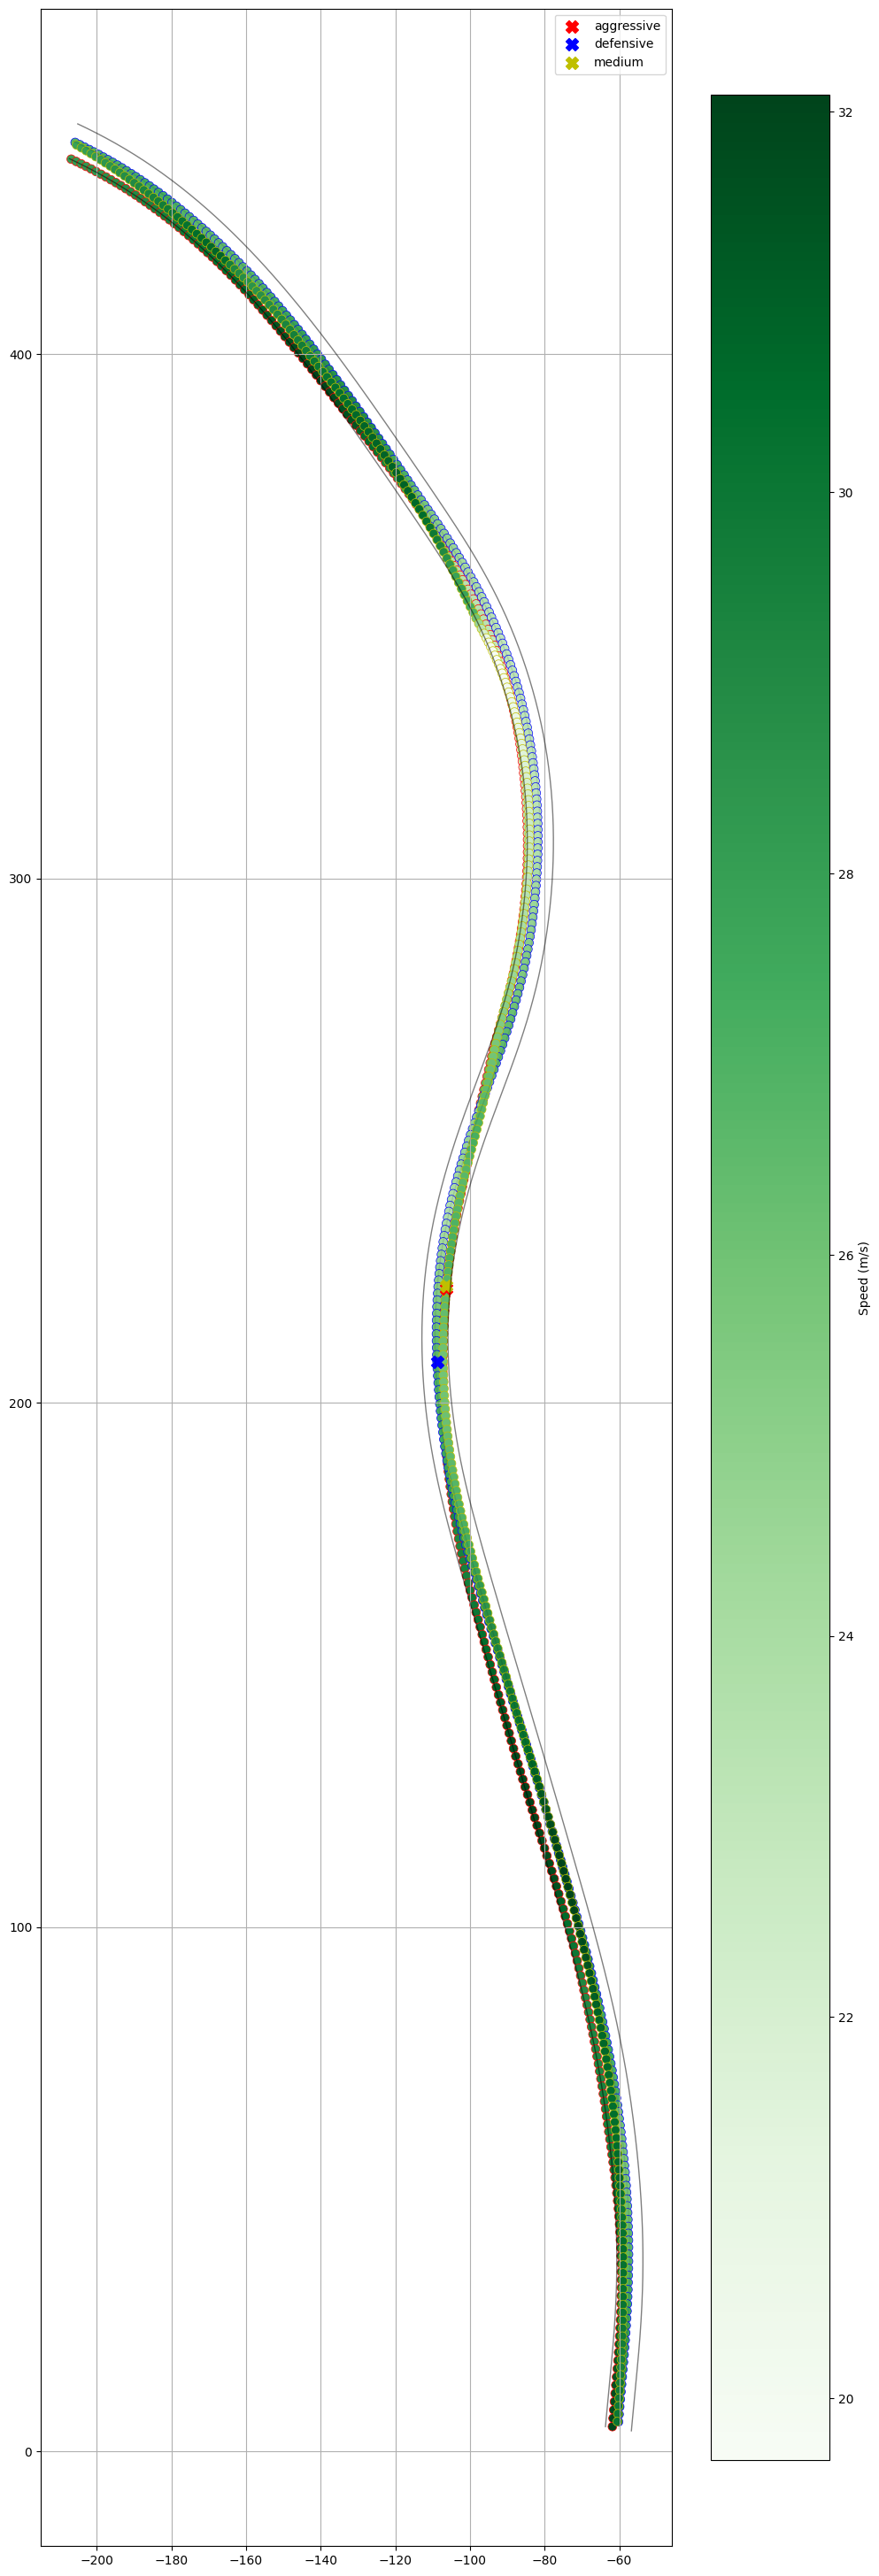

In [176]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from matplotlib import cm
 

corner_num = 3

start = corner_meta['corner_segments'][corner_num][0] # 1740 #1800 #
end = corner_meta['corner_segments'][corner_num][1] #2020 #

start_x, start_y = nam_track_dict['x'][start], nam_track_dict['y'][start]
end_x, end_y = nam_track_dict['x'][end], nam_track_dict['y'][end]

mx, Mx = min(nam_track_dict['x'][start:end]), max(nam_track_dict['x'][start:end])
my, My = min(nam_track_dict['y'][start:end]), max(nam_track_dict['y'][start:end])
diff_x, diff_y = abs(Mx - mx), abs(My - my)


fig, ax = plt.subplots(figsize=(10, 10 * (diff_y / diff_x)))
plt.plot(nam_track_dict['x'][start:end+1], nam_track_dict['y'][start:end+1], linewidth=1, c='k', alpha=0.1)
plt.plot(nam_track_dict['left'][start:end+1, 0], nam_track_dict['left'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)
plt.plot(nam_track_dict['right'][start:end+1, 0], nam_track_dict['right'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)


agg_x, agg_y = agg_car_state[:, 0], agg_car_state[:, 1]
def_x, def_y = def_car_state[:, 0], def_car_state[:, 1]
med_x, med_y = med_car_state[:, 0], med_car_state[:, 1]

agg_pts = [];agg_vel = []
for i, (x, y) in enumerate(zip(agg_x, agg_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        agg_pts.append([x, y])
        agg_vel.append(agg_car_status[i, 0])
agg_pts = np.array(agg_pts).T


def_pts = [];def_vel = []
for i, (x, y) in enumerate(zip(def_x, def_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        def_pts.append([x, y])
        def_vel.append(def_car_status[i, 0])
def_pts = np.array(def_pts).T

med_pts = [];med_vel = []
for i, (x, y) in enumerate(zip(med_x, med_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        med_pts.append([x, y])
        med_vel.append(med_car_status[i, 0])
med_pts = np.array(med_pts).T

norm = Normalize(vmin =min(min(agg_vel), min(def_vel), min(med_vel)), vmax=max(max(agg_vel), max(def_vel), max(med_vel)))
# cmap = LinearSegmentedColormap.from_list("white_red", ["white", "red"])
cmap = cm.Greens

sc = plt.scatter(agg_pts[0], agg_pts[1],  s=50, c=agg_vel, norm=norm, cmap=cmap, edgecolors='r', linewidths=0.5) #c=cmap(norm(agg_vel))) #label='aggressive');
# plt.plot(agg_pts[0], agg_pts[1], color='r', linewidth=2, alpha=0.5)
plt.scatter(def_pts[0], def_pts[1],  s=50, c=cmap(norm(def_vel)), edgecolors='b', linewidths=0.5) #label='defensive');
# plt.plot(def_pts[0], def_pts[1], color='b', linewidth=2, alpha=0.5)
plt.scatter(med_pts[0], med_pts[1],  s=50, c=cmap(norm(med_vel)), edgecolors='y', linewidths=0.5) #label='medium')
# plt.plot(med_pts[0], med_pts[1], color='y', linewidth=2, alpha=0.5)
    
plt.scatter(agg_points[corner_num][0], agg_points[corner_num][1], s=100, c='r', marker='X', label='aggressive')
plt.scatter(def_points[corner_num][0], def_points[corner_num][1], s=100, c='b', marker='X', label='defensive')
plt.scatter(med_points[corner_num][0], med_points[corner_num][1], s=100, c='y', marker='X', label='medium')

cbar = plt.colorbar(sc, label="Speed (m/s)")
cbar.ax.tick_params(labelsize=10)

fig.tight_layout()
plt.legend()
plt.grid()

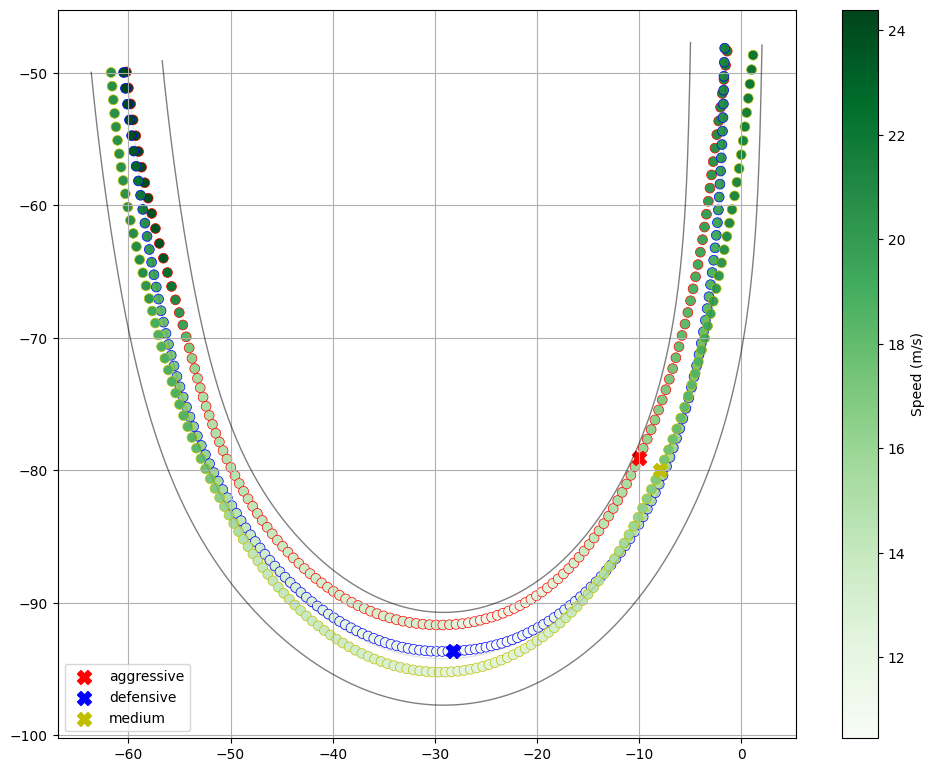

In [20]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from matplotlib import cm
 

corner_num = 4

start =1740 #corner_meta['corner_segments'][corner_num][0] # 1740 #1800 #
end =2020 # corner_meta['corner_segments'][corner_num][1] #2020 #

start_x, start_y = nam_track_dict['x'][start], nam_track_dict['y'][start]
end_x, end_y = nam_track_dict['x'][end], nam_track_dict['y'][end]

mx, Mx = min(nam_track_dict['x'][start:end]), max(nam_track_dict['x'][start:end])
my, My = min(nam_track_dict['y'][start:end]), max(nam_track_dict['y'][start:end])
diff_x, diff_y = abs(Mx - mx), abs(My - my)


fig, ax = plt.subplots(figsize=(10, 10 * (diff_y / diff_x)))
plt.plot(nam_track_dict['x'][start:end+1], nam_track_dict['y'][start:end+1], linewidth=1, c='k', alpha=0.1)
plt.plot(nam_track_dict['left'][start:end+1, 0], nam_track_dict['left'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)
plt.plot(nam_track_dict['right'][start:end+1, 0], nam_track_dict['right'][start:end+1, 1], linewidth=1, c='k', alpha=0.5)


agg_x, agg_y = agg_car_state[:, 0], agg_car_state[:, 1]
def_x, def_y = def_car_state[:, 0], def_car_state[:, 1]
med_x, med_y = med_car_state[:, 0], med_car_state[:, 1]

agg_pts = [];agg_vel = []
for i, (x, y) in enumerate(zip(agg_x, agg_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        agg_pts.append([x, y])
        agg_vel.append(agg_car_status[i, 0])
agg_pts = np.array(agg_pts).T


def_pts = [];def_vel = []
for i, (x, y) in enumerate(zip(def_x, def_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        def_pts.append([x, y])
        def_vel.append(def_car_status[i, 0])
def_pts = np.array(def_pts).T

med_pts = [];med_vel = []
for i, (x, y) in enumerate(zip(med_x, med_y)):
    theta = _get_closest_theta(cx=x, cy=y, spline=theta_spline, track_dict=nam_track_dict)
    if nam_track_dict['theta'][start] <= theta <= nam_track_dict['theta'][end]:
        med_pts.append([x, y])
        med_vel.append(med_car_status[i, 0])
med_pts = np.array(med_pts).T

norm = Normalize(vmin =min(min(agg_vel), min(def_vel), min(med_vel)), vmax=max(max(agg_vel), max(def_vel), max(med_vel)))
# cmap = LinearSegmentedColormap.from_list("white_red", ["white", "red"])
cmap = cm.Greens

sc = plt.scatter(agg_pts[0], agg_pts[1],  s=50, c=agg_vel, norm=norm, cmap=cmap, edgecolors='r', linewidths=0.5) #c=cmap(norm(agg_vel))) #label='aggressive');
# plt.plot(agg_pts[0], agg_pts[1], color='r', linewidth=2, alpha=0.5)
plt.scatter(def_pts[0], def_pts[1],  s=50, c=cmap(norm(def_vel)), edgecolors='b', linewidths=0.5) #label='defensive');
# plt.plot(def_pts[0], def_pts[1], color='b', linewidth=2, alpha=0.5)
plt.scatter(med_pts[0], med_pts[1],  s=50, c=cmap(norm(med_vel)), edgecolors='y', linewidths=0.5) #label='medium')
# plt.plot(med_pts[0], med_pts[1], color='y', linewidth=2, alpha=0.5)
    
plt.scatter(agg_points[corner_num][0], agg_points[corner_num][1], s=100, c='r', marker='X', label='aggressive')
plt.scatter(def_points[corner_num][0], def_points[corner_num][1], s=100, c='b', marker='X', label='defensive')
plt.scatter(med_points[corner_num][0], med_points[corner_num][1], s=100, c='y', marker='X', label='medium')

cbar = plt.colorbar(sc, label="Speed (m/s)")
cbar.ax.tick_params(labelsize=10)

fig.tight_layout()
plt.legend()
plt.grid()

In [24]:
corner_num=2
agg_apex_theta = _get_closest_theta(cx=agg_points[corner_num][0], cy=agg_points[corner_num][1], spline=theta_spline, track_dict=nam_track_dict)
def_apex_theta = _get_closest_theta(cx=def_points[corner_num][0], cy=def_points[corner_num][1], spline=theta_spline, track_dict=nam_track_dict)
print(agg_apex_theta-def_apex_theta)


-89.43821874945593


In [25]:
corner_num=4
agg_apex_theta = _get_closest_theta(cx=agg_points[corner_num][0], cy=agg_points[corner_num][1], spline=theta_spline, track_dict=nam_track_dict)
def_apex_theta = _get_closest_theta(cx=def_points[corner_num][0], cy=def_points[corner_num][1], spline=theta_spline, track_dict=nam_track_dict)
print(agg_apex_theta - def_apex_theta)


25.910675585485023


`Compare the control values matched with the theta value`

In [25]:
agg_car_action['steer']

[np.float64(0.0),
 np.float32(-0.91370046),
 np.float32(-0.7977446),
 np.float32(-0.5301409),
 np.float32(-0.18514971),
 np.float32(-0.9678972),
 np.float32(-0.92784685),
 np.float32(-0.80642015),
 np.float32(-0.23516919),
 np.float32(-0.11785744),
 np.float32(-0.089103274),
 np.float32(0.11033235),
 np.float32(-0.3302789),
 np.float32(0.6240026),
 np.float32(0.18202457),
 np.float32(-0.3866955),
 np.float32(0.39339724),
 np.float32(-0.40302786),
 np.float32(0.31549102),
 np.float32(-0.4709125),
 np.float32(0.1697198),
 np.float32(-0.48549697),
 np.float32(0.24741392),
 np.float32(-0.475449),
 np.float32(0.23001856),
 np.float32(-0.49956855),
 np.float32(0.17032062),
 np.float32(-0.48683733),
 np.float32(0.2477174),
 np.float32(-0.47749886),
 np.float32(0.22528459),
 np.float32(-0.50561285),
 np.float32(0.1557983),
 np.float32(-0.47970343),
 np.float32(0.27146727),
 np.float32(-0.45617244),
 np.float32(0.2683646),
 np.float32(-0.48653057),
 np.float32(0.1808738),
 np.float32(-0.5104220

In [ ]:
agg_car_action = _get_interp_vel(track_dict=nam_track_dict, x_arr=med_car_state.T[0], y_arr=med_car_state.T[1], theta_spline=theta_spline, v_arr=agg_car_action)
